# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import datetime
import plotly.express as px


from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, cohen_kappa_score,roc_curve,auc
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Utility Functions

In [38]:
def determine_outlier_thresholds_iqr(dataframe, col_name, th1=0.25, th3=0.75):
    '''
    Function to detect outliers, IQR used when the data is right or left skewed
    '''
    quartile1 = dataframe[col_name].quantile(th1)
    quartile3 = dataframe[col_name].quantile(th3)
    iqr = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * iqr
    lower_limit = quartile1 - 1.5 * iqr
    return lower_limit, upper_limit

In [3]:
def preprocess_clustering_dataframe(transactions_df):
    '''
    Adding columns for number of transactions per merchant, total transaction amount per merchant, Average day difference per
    merchant between transactions (Everything aggregated at merchant level)
    params: original_transactions_df
    returns: preprocessed dataframe for merchant clustering
    '''
    unique_merchants=np.unique(transactions_df['merchant'])

    merchant_preprocessed_df=pd.DataFrame(columns=['merchant', 'number_of_transactions', 'total_amount', 'average_frequency'])

    for idx, merchant in enumerate(unique_merchants):

        merchant_df=transactions_df.loc[transactions_df['merchant']==merchant]

        number_of_transactions=len(merchant_df)
        total_amount=sum(merchant_df['amount_usd_in_cents'])

        merchant_df=merchant_df.sort_values(by=['date'], ascending=True)
        date_list=list(merchant_df['date'])
        total_day_difference=0
        previous_date=date_list[0]
        for date in date_list:
            total_day_difference+=(date-previous_date).days
            previous_date=date

        if len(merchant_df)>1:
            average_frequency=total_day_difference/(len(merchant_df)-1)
        else:
            average_frequency=0

        merchant_preprocessed_df.loc[len(merchant_preprocessed_df.index)] = [merchant, number_of_transactions, total_amount,average_frequency]

        print ("Processing progress: ", idx*100/len(unique_merchants))

    merchant_preprocessed_df.to_csv('./merchant_clustering_dataframe.csv', index=None)
    
    return merchant_preprocessed_df

In [66]:
def preprocess_churnprediction_dataframe(transactions_df, merchant_clustering_df, churn_interval):
    '''
    Adding columns for churn, last_transaction_amount and last_transaction_date of merchants
    params: original transactions dataframe, clustering dataframe churn interval determined using 
    average frequency column distribution
    returns: Dataframe for churn prediction
    '''
    unique_merchants=np.unique(transactions_df['merchant'])
    
    merchant_churnprediction_df=pd.DataFrame(columns=['merchant', 'churn','last_transaction_date', 'last_transaction_amount'])
    
    for idx, merchant in enumerate(unique_merchants):

        merchant_df=transactions_df.loc[transactions_df['merchant']==merchant]

        merchant_df=merchant_df.sort_values(by=['date'], ascending=True)
        date_list=list(merchant_df['date'])
        previous_date=date_list[-1]

        last_date=datetime.date(2034,12,31)
        if (last_date-previous_date).days<=churn_interval:
            churn=0
        else:
            churn=1

        timestamp=(previous_date-datetime.date(2033,1,1)).total_seconds()
        last_amount=list(merchant_df['amount_usd_in_cents'])[-1]

        merchant_churnprediction_df.loc[len(merchant_churnprediction_df.index)] = [merchant, churn, timestamp, last_amount]

        print ("Processing progress: ", idx*100/len(unique_merchants))

    merchant_churnprediction_df=merchant_churnprediction_df.merge(merchant_clustering_df, how='left', on='merchant')
    
    merchant_churnprediction_df.to_csv('./merchant_churnprediction_dataframe.csv', index=None)
    
    return merchant_churnprediction_df

# Exploratory Data Analysis

In [26]:
transactions_df=pd.read_csv('takehome_ds_written.csv')

In [6]:
transactions_df.head(10)

,Unnamed: 0,merchant,time,amount_usd_in_cents
0,1,faa029c6b0,2034-06-17 23:34:14,6349
1,2,ed7a7d91aa,2034-12-27 00:40:38,3854
2,3,5608f200cf,2034-04-30 01:29:42,789
3,4,15b1a0d61e,2034-09-16 01:06:23,4452
4,5,4770051790,2034-07-22 16:21:42,20203
5,6,3fc4f08d9d,2034-08-12 10:54:48,6190
6,7,1c8b539073,2033-03-10 18:46:49,715
7,8,77f961f9b3,2034-12-09 21:27:18,7211
8,9,9cb79b7700,2034-03-27 23:01:13,23267
9,10,2f95149dc3,2034-01-24 21:17:22,2572


In [7]:
transactions_df=transactions_df.drop(columns=['Unnamed: 0'])
transactions_df.describe()

,amount_usd_in_cents
count,1.513719e+06
mean,1.548466e+04
std,6.161886e+04
min,2.010000e+02
25%,3.215000e+03
50%,6.104000e+03
75%,1.260600e+04
max,2.592028e+07


In [116]:
print ("Column names in the CSV: ", transactions_df.columns)
print ("Total number of rows in the CSV:", len(transactions_df))
print ("Number of unique merchants:", len(np.unique(transactions_df['merchant'])))
print ("Range of Transaction amounts: ", np.min(transactions_df['amount_usd_in_cents']), np.max(transactions_df['amount_usd_in_cents']))

Column names in the CSV:  Index(['Unnamed: 0', 'merchant', 'time', 'amount_usd_in_cents'], dtype='object')
Total number of rows in the CSV: 1513719
Number of unique merchants: 14351
Range of Transaction amounts:  201 25920280


<AxesSubplot:xlabel='amount_usd_in_cents', ylabel='Count'>

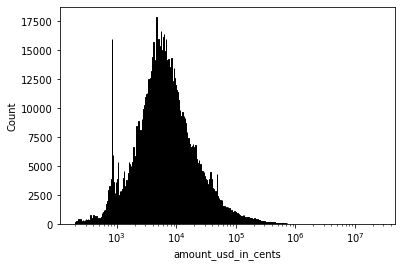

In [12]:
sns.histplot(data=transactions_df, x="amount_usd_in_cents", log_scale=True)

In [13]:
'''
We see the amounts are normally distributed. There are chances of outliers in the right tail of the distribution, but 
since the maximum value is well within the transaction limit of Stripe currently, we do not remove them
'''

'\nWe see the amounts are normally distributed. There are chances of outliers in the right tail of the distribution, but \nsince the maximum value is well within the transaction limit of Stripe currently, we do not remove them\n'

# Data Transformations

In [15]:
# Convert time in strings to dates. We use this information later for adding features like average transaction frequency of the
# merchant
transactions_cleaned_df=transactions_df

date_list=pd.to_datetime(transactions_cleaned_df['time'])
transactions_cleaned_df['date']=date_list.dt.date

transactions_cleaned_df=transactions_cleaned_df.drop(['time'], axis=1)
transactions_cleaned_df.sample(5)

,merchant,amount_usd_in_cents,date
819538,f591f18a05,1759,2034-04-03
1314863,36745cc693,973,2033-11-08
1021507,1ddaea9838,1808,2033-07-01
846980,dfb1f143d8,794,2034-04-18
126328,f551f52a74,633,2033-02-20


In [16]:
#Adding new columns: Number of orders per merchant, total amount per merchant, Average Transaction frequency(days) per merchant
merchant_clustering_df=preprocess_clustering_dataframe(transactions_cleaned_df)

Processing progress:  0.0
Processing progress:  0.006968155529231412
Processing progress:  0.013936311058462825
Processing progress:  0.020904466587694237
Processing progress:  0.02787262211692565
Processing progress:  0.03484077764615706
Processing progress:  0.041808933175388474
Processing progress:  0.048777088704619886
Processing progress:  0.0557452442338513
Processing progress:  0.06271339976308271
Processing progress:  0.06968155529231412
Processing progress:  0.07664971082154554
Processing progress:  0.08361786635077695
Processing progress:  0.09058602188000836
Processing progress:  0.09755417740923977
Processing progress:  0.10452233293847119
Processing progress:  0.1114904884677026
Processing progress:  0.11845864399693401
Processing progress:  0.12542679952616542
Processing progress:  0.13239495505539683
Processing progress:  0.13936311058462825
Processing progress:  0.14633126611385966
Processing progress:  0.15329942164309107
Processing progress:  0.16026757717232248
Proce

Processing progress:  1.4005992613755138
Processing progress:  1.4075674169047454
Processing progress:  1.4145355724339768
Processing progress:  1.4215037279632081
Processing progress:  1.4284718834924395
Processing progress:  1.435440039021671
Processing progress:  1.4424081945509024
Processing progress:  1.4493763500801338
Processing progress:  1.4563445056093651
Processing progress:  1.4633126611385967
Processing progress:  1.470280816667828
Processing progress:  1.4772489721970594
Processing progress:  1.4842171277262908
Processing progress:  1.4911852832555224
Processing progress:  1.4981534387847537
Processing progress:  1.505121594313985
Processing progress:  1.5120897498432164
Processing progress:  1.519057905372448
Processing progress:  1.5260260609016794
Processing progress:  1.5329942164309107
Processing progress:  1.539962371960142
Processing progress:  1.5469305274893737
Processing progress:  1.553898683018605
Processing progress:  1.5608668385478364
Processing progress:  

Processing progress:  2.808166678280259
Processing progress:  2.815134833809491
Processing progress:  2.822102989338722
Processing progress:  2.8290711448679535
Processing progress:  2.836039300397185
Processing progress:  2.8430074559264162
Processing progress:  2.8499756114556476
Processing progress:  2.856943766984879
Processing progress:  2.8639119225141103
Processing progress:  2.870880078043342
Processing progress:  2.8778482335725735
Processing progress:  2.884816389101805
Processing progress:  2.891784544631036
Processing progress:  2.8987527001602675
Processing progress:  2.905720855689499
Processing progress:  2.9126890112187303
Processing progress:  2.9196571667479616
Processing progress:  2.9266253222771934
Processing progress:  2.9335934778064248
Processing progress:  2.940561633335656
Processing progress:  2.9475297888648875
Processing progress:  2.954497944394119
Processing progress:  2.96146609992335
Processing progress:  2.9684342554525815
Processing progress:  2.97540

Processing progress:  4.222702250714236
Processing progress:  4.229670406243468
Processing progress:  4.236638561772699
Processing progress:  4.2436067173019305
Processing progress:  4.250574872831161
Processing progress:  4.257543028360393
Processing progress:  4.264511183889624
Processing progress:  4.271479339418856
Processing progress:  4.278447494948087
Processing progress:  4.285415650477319
Processing progress:  4.2923838060065505
Processing progress:  4.299351961535781
Processing progress:  4.306320117065013
Processing progress:  4.313288272594244
Processing progress:  4.320256428123476
Processing progress:  4.327224583652707
Processing progress:  4.334192739181939
Processing progress:  4.34116089471117
Processing progress:  4.348129050240401
Processing progress:  4.355097205769633
Processing progress:  4.362065361298864
Processing progress:  4.369033516828096
Processing progress:  4.376001672357327
Processing progress:  4.3829698278865585
Processing progress:  4.38993798341578

Processing progress:  5.651174134206675
Processing progress:  5.658142289735907
Processing progress:  5.665110445265138
Processing progress:  5.67207860079437
Processing progress:  5.679046756323602
Processing progress:  5.6860149118528325
Processing progress:  5.692983067382064
Processing progress:  5.699951222911295
Processing progress:  5.706919378440527
Processing progress:  5.713887533969758
Processing progress:  5.72085568949899
Processing progress:  5.727823845028221
Processing progress:  5.734792000557452
Processing progress:  5.741760156086684
Processing progress:  5.748728311615915
Processing progress:  5.755696467145147
Processing progress:  5.762664622674378
Processing progress:  5.76963277820361
Processing progress:  5.776600933732841
Processing progress:  5.783569089262072
Processing progress:  5.790537244791304
Processing progress:  5.797505400320535
Processing progress:  5.804473555849767
Processing progress:  5.811441711378998
Processing progress:  5.81840986690823
Pro

Processing progress:  7.093582328757578
Processing progress:  7.100550484286809
Processing progress:  7.107518639816041
Processing progress:  7.114486795345272
Processing progress:  7.1214549508745035
Processing progress:  7.128423106403735
Processing progress:  7.135391261932966
Processing progress:  7.142359417462198
Processing progress:  7.149327572991429
Processing progress:  7.156295728520661
Processing progress:  7.163263884049892
Processing progress:  7.1702320395791235
Processing progress:  7.177200195108354
Processing progress:  7.184168350637586
Processing progress:  7.191136506166818
Processing progress:  7.198104661696049
Processing progress:  7.205072817225281
Processing progress:  7.212040972754512
Processing progress:  7.219009128283743
Processing progress:  7.225977283812974
Processing progress:  7.232945439342206
Processing progress:  7.239913594871438
Processing progress:  7.246881750400669
Processing progress:  7.253849905929901
Processing progress:  7.26081806145913

Processing progress:  8.535990523308481
Processing progress:  8.542958678837712
Processing progress:  8.549926834366943
Processing progress:  8.556894989896174
Processing progress:  8.563863145425406
Processing progress:  8.570831300954637
Processing progress:  8.577799456483868
Processing progress:  8.584767612013101
Processing progress:  8.591735767542332
Processing progress:  8.598703923071563
Processing progress:  8.605672078600794
Processing progress:  8.612640234130026
Processing progress:  8.619608389659257
Processing progress:  8.626576545188488
Processing progress:  8.63354470071772
Processing progress:  8.640512856246952
Processing progress:  8.647481011776183
Processing progress:  8.654449167305414
Processing progress:  8.661417322834646
Processing progress:  8.668385478363877
Processing progress:  8.675353633893108
Processing progress:  8.68232178942234
Processing progress:  8.689289944951572
Processing progress:  8.696258100480803
Processing progress:  8.703226256010034
Pr

Processing progress:  9.978398717859383
Processing progress:  9.985366873388614
Processing progress:  9.992335028917845
Processing progress:  9.999303184447077
Processing progress:  10.006271339976308
Processing progress:  10.01323949550554
Processing progress:  10.020207651034772
Processing progress:  10.027175806564003
Processing progress:  10.034143962093234
Processing progress:  10.041112117622465
Processing progress:  10.048080273151697
Processing progress:  10.055048428680928
Processing progress:  10.06201658421016
Processing progress:  10.06898473973939
Processing progress:  10.075952895268623
Processing progress:  10.082921050797854
Processing progress:  10.089889206327085
Processing progress:  10.096857361856317
Processing progress:  10.103825517385548
Processing progress:  10.11079367291478
Processing progress:  10.11776182844401
Processing progress:  10.124729983973243
Processing progress:  10.131698139502474
Processing progress:  10.138666295031705
Processing progress:  10.

Processing progress:  11.39293429029336
Processing progress:  11.39990244582259
Processing progress:  11.406870601351821
Processing progress:  11.413838756881054
Processing progress:  11.420806912410285
Processing progress:  11.427775067939516
Processing progress:  11.434743223468748
Processing progress:  11.44171137899798
Processing progress:  11.44867953452721
Processing progress:  11.455647690056441
Processing progress:  11.462615845585674
Processing progress:  11.469584001114905
Processing progress:  11.476552156644136
Processing progress:  11.483520312173368
Processing progress:  11.4904884677026
Processing progress:  11.49745662323183
Processing progress:  11.504424778761061
Processing progress:  11.511392934290294
Processing progress:  11.518361089819525
Processing progress:  11.525329245348756
Processing progress:  11.532297400877988
Processing progress:  11.53926555640722
Processing progress:  11.54623371193645
Processing progress:  11.553201867465681
Processing progress:  11.

Processing progress:  12.800501707198105
Processing progress:  12.807469862727336
Processing progress:  12.814438018256567
Processing progress:  12.8214061737858
Processing progress:  12.82837432931503
Processing progress:  12.835342484844261
Processing progress:  12.842310640373492
Processing progress:  12.849278795902725
Processing progress:  12.856246951431956
Processing progress:  12.863215106961187
Processing progress:  12.87018326249042
Processing progress:  12.87715141801965
Processing progress:  12.884119573548881
Processing progress:  12.891087729078112
Processing progress:  12.898055884607345
Processing progress:  12.905024040136576
Processing progress:  12.911992195665807
Processing progress:  12.91896035119504
Processing progress:  12.92592850672427
Processing progress:  12.932896662253501
Processing progress:  12.939864817782732
Processing progress:  12.946832973311965
Processing progress:  12.953801128841196
Processing progress:  12.960769284370427
Processing progress:  1

Processing progress:  14.201100968573618
Processing progress:  14.20806912410285
Processing progress:  14.215037279632082
Processing progress:  14.222005435161313
Processing progress:  14.228973590690543
Processing progress:  14.235941746219776
Processing progress:  14.242909901749007
Processing progress:  14.249878057278238
Processing progress:  14.25684621280747
Processing progress:  14.263814368336702
Processing progress:  14.270782523865932
Processing progress:  14.277750679395163
Processing progress:  14.284718834924396
Processing progress:  14.291686990453627
Processing progress:  14.298655145982858
Processing progress:  14.30562330151209
Processing progress:  14.312591457041322
Processing progress:  14.319559612570552
Processing progress:  14.326527768099783
Processing progress:  14.333495923629016
Processing progress:  14.340464079158247
Processing progress:  14.347432234687478
Processing progress:  14.354400390216709
Processing progress:  14.361368545745941
Processing progress

Processing progress:  15.608668385478364
Processing progress:  15.615636541007595
Processing progress:  15.622604696536827
Processing progress:  15.629572852066058
Processing progress:  15.636541007595289
Processing progress:  15.643509163124522
Processing progress:  15.650477318653753
Processing progress:  15.657445474182984
Processing progress:  15.664413629712215
Processing progress:  15.671381785241447
Processing progress:  15.678349940770678
Processing progress:  15.685318096299909
Processing progress:  15.69228625182914
Processing progress:  15.699254407358373
Processing progress:  15.706222562887604
Processing progress:  15.713190718416834
Processing progress:  15.720158873946067
Processing progress:  15.727127029475298
Processing progress:  15.734095185004529
Processing progress:  15.74106334053376
Processing progress:  15.748031496062993
Processing progress:  15.754999651592223
Processing progress:  15.761967807121454
Processing progress:  15.768935962650687
Processing progres

Processing progress:  17.02320395791234
Processing progress:  17.030172113441573
Processing progress:  17.037140268970802
Processing progress:  17.044108424500035
Processing progress:  17.051076580029267
Processing progress:  17.058044735558497
Processing progress:  17.06501289108773
Processing progress:  17.071981046616962
Processing progress:  17.07894920214619
Processing progress:  17.085917357675424
Processing progress:  17.092885513204656
Processing progress:  17.099853668733886
Processing progress:  17.10682182426312
Processing progress:  17.113789979792347
Processing progress:  17.12075813532158
Processing progress:  17.127726290850813
Processing progress:  17.134694446380042
Processing progress:  17.141662601909275
Processing progress:  17.148630757438507
Processing progress:  17.155598912967736
Processing progress:  17.16256706849697
Processing progress:  17.169535224026202
Processing progress:  17.17650337955543
Processing progress:  17.183471535084664
Processing progress:  1

Processing progress:  18.437739530346317
Processing progress:  18.44470768587555
Processing progress:  18.45167584140478
Processing progress:  18.45864399693401
Processing progress:  18.465612152463244
Processing progress:  18.472580307992473
Processing progress:  18.479548463521706
Processing progress:  18.48651661905094
Processing progress:  18.493484774580168
Processing progress:  18.5004529301094
Processing progress:  18.507421085638633
Processing progress:  18.514389241167862
Processing progress:  18.521357396697095
Processing progress:  18.528325552226324
Processing progress:  18.535293707755557
Processing progress:  18.54226186328479
Processing progress:  18.54923001881402
Processing progress:  18.55619817434325
Processing progress:  18.563166329872484
Processing progress:  18.570134485401713
Processing progress:  18.577102640930946
Processing progress:  18.58407079646018
Processing progress:  18.591038951989407
Processing progress:  18.59800710751864
Processing progress:  18.60

Processing progress:  19.845306947251064
Processing progress:  19.852275102780293
Processing progress:  19.859243258309526
Processing progress:  19.866211413838755
Processing progress:  19.873179569367988
Processing progress:  19.88014772489722
Processing progress:  19.88711588042645
Processing progress:  19.894084035955682
Processing progress:  19.901052191484915
Processing progress:  19.908020347014144
Processing progress:  19.914988502543377
Processing progress:  19.92195665807261
Processing progress:  19.92892481360184
Processing progress:  19.93589296913107
Processing progress:  19.942861124660304
Processing progress:  19.949829280189533
Processing progress:  19.956797435718766
Processing progress:  19.963765591247995
Processing progress:  19.970733746777228
Processing progress:  19.97770190230646
Processing progress:  19.98467005783569
Processing progress:  19.991638213364922
Processing progress:  19.998606368894155
Processing progress:  20.005574524423384
Processing progress:  2

Processing progress:  21.252874364155808
Processing progress:  21.25984251968504
Processing progress:  21.26681067521427
Processing progress:  21.273778830743503
Processing progress:  21.280746986272735
Processing progress:  21.287715141801964
Processing progress:  21.294683297331197
Processing progress:  21.301651452860426
Processing progress:  21.30861960838966
Processing progress:  21.31558776391889
Processing progress:  21.32255591944812
Processing progress:  21.329524074977353
Processing progress:  21.336492230506586
Processing progress:  21.343460386035815
Processing progress:  21.350428541565048
Processing progress:  21.35739669709428
Processing progress:  21.36436485262351
Processing progress:  21.371333008152742
Processing progress:  21.378301163681975
Processing progress:  21.385269319211204
Processing progress:  21.392237474740437
Processing progress:  21.399205630269666
Processing progress:  21.4061737857989
Processing progress:  21.41314194132813
Processing progress:  21.4

Processing progress:  22.660441781060552
Processing progress:  22.667409936589785
Processing progress:  22.674378092119017
Processing progress:  22.681346247648246
Processing progress:  22.68831440317748
Processing progress:  22.69528255870671
Processing progress:  22.70225071423594
Processing progress:  22.709218869765174
Processing progress:  22.716187025294406
Processing progress:  22.723155180823635
Processing progress:  22.730123336352868
Processing progress:  22.737091491882097
Processing progress:  22.74405964741133
Processing progress:  22.751027802940563
Processing progress:  22.75799595846979
Processing progress:  22.764964113999024
Processing progress:  22.771932269528257
Processing progress:  22.778900425057486
Processing progress:  22.78586858058672
Processing progress:  22.79283673611595
Processing progress:  22.79980489164518
Processing progress:  22.806773047174413
Processing progress:  22.813741202703643
Processing progress:  22.820709358232875
Processing progress:  22

Processing progress:  24.07497735349453
Processing progress:  24.08194550902376
Processing progress:  24.088913664552994
Processing progress:  24.095881820082223
Processing progress:  24.102849975611456
Processing progress:  24.10981813114069
Processing progress:  24.116786286669917
Processing progress:  24.12375444219915
Processing progress:  24.130722597728383
Processing progress:  24.137690753257612
Processing progress:  24.144658908786845
Processing progress:  24.151627064316077
Processing progress:  24.158595219845306
Processing progress:  24.16556337537454
Processing progress:  24.17253153090377
Processing progress:  24.179499686433
Processing progress:  24.186467841962234
Processing progress:  24.193435997491463
Processing progress:  24.200404153020695
Processing progress:  24.207372308549928
Processing progress:  24.214340464079157
Processing progress:  24.22130861960839
Processing progress:  24.228276775137623
Processing progress:  24.235244930666852
Processing progress:  24.2

Processing progress:  25.496481081457738
Processing progress:  25.50344923698697
Processing progress:  25.5104173925162
Processing progress:  25.517385548045432
Processing progress:  25.524353703574665
Processing progress:  25.531321859103894
Processing progress:  25.538290014633127
Processing progress:  25.54525817016236
Processing progress:  25.55222632569159
Processing progress:  25.55919448122082
Processing progress:  25.566162636750054
Processing progress:  25.573130792279283
Processing progress:  25.580098947808516
Processing progress:  25.587067103337745
Processing progress:  25.594035258866978
Processing progress:  25.60100341439621
Processing progress:  25.60797156992544
Processing progress:  25.614939725454672
Processing progress:  25.621907880983905
Processing progress:  25.628876036513134
Processing progress:  25.635844192042367
Processing progress:  25.6428123475716
Processing progress:  25.64978050310083
Processing progress:  25.65674865863006
Processing progress:  25.663

Processing progress:  26.911016653891714
Processing progress:  26.917984809420947
Processing progress:  26.924952964950176
Processing progress:  26.93192112047941
Processing progress:  26.93888927600864
Processing progress:  26.94585743153787
Processing progress:  26.952825587067103
Processing progress:  26.959793742596336
Processing progress:  26.966761898125565
Processing progress:  26.973730053654798
Processing progress:  26.98069820918403
Processing progress:  26.98766636471326
Processing progress:  26.994634520242492
Processing progress:  27.001602675771725
Processing progress:  27.008570831300954
Processing progress:  27.015538986830187
Processing progress:  27.022507142359416
Processing progress:  27.02947529788865
Processing progress:  27.03644345341788
Processing progress:  27.04341160894711
Processing progress:  27.050379764476343
Processing progress:  27.057347920005576
Processing progress:  27.064316075534805
Processing progress:  27.071284231064038
Processing progress:  27

Processing progress:  28.32555222632569
Processing progress:  28.332520381854923
Processing progress:  28.339488537384156
Processing progress:  28.346456692913385
Processing progress:  28.353424848442618
Processing progress:  28.360393003971847
Processing progress:  28.36736115950108
Processing progress:  28.374329315030312
Processing progress:  28.38129747055954
Processing progress:  28.388265626088774
Processing progress:  28.395233781618007
Processing progress:  28.402201937147236
Processing progress:  28.40917009267647
Processing progress:  28.4161382482057
Processing progress:  28.42310640373493
Processing progress:  28.430074559264163
Processing progress:  28.437042714793396
Processing progress:  28.444010870322625
Processing progress:  28.450979025851858
Processing progress:  28.457947181381087
Processing progress:  28.46491533691032
Processing progress:  28.471883492439552
Processing progress:  28.47885164796878
Processing progress:  28.485819803498014
Processing progress:  28.

Processing progress:  29.7470559542889
Processing progress:  29.754024109818133
Processing progress:  29.76099226534736
Processing progress:  29.767960420876594
Processing progress:  29.774928576405827
Processing progress:  29.781896731935056
Processing progress:  29.78886488746429
Processing progress:  29.795833042993518
Processing progress:  29.80280119852275
Processing progress:  29.809769354051983
Processing progress:  29.816737509581213
Processing progress:  29.823705665110445
Processing progress:  29.830673820639678
Processing progress:  29.837641976168907
Processing progress:  29.84461013169814
Processing progress:  29.851578287227372
Processing progress:  29.8585464427566
Processing progress:  29.865514598285834
Processing progress:  29.872482753815063
Processing progress:  29.879450909344296
Processing progress:  29.88641906487353
Processing progress:  29.893387220402758
Processing progress:  29.90035537593199
Processing progress:  29.907323531461223
Processing progress:  29.9

Processing progress:  31.16855968225211
Processing progress:  31.17552783778134
Processing progress:  31.18249599331057
Processing progress:  31.189464148839804
Processing progress:  31.196432304369033
Processing progress:  31.203400459898265
Processing progress:  31.210368615427495
Processing progress:  31.217336770956727
Processing progress:  31.22430492648596
Processing progress:  31.23127308201519
Processing progress:  31.238241237544422
Processing progress:  31.245209393073655
Processing progress:  31.252177548602884
Processing progress:  31.259145704132116
Processing progress:  31.26611385966135
Processing progress:  31.273082015190578
Processing progress:  31.28005017071981
Processing progress:  31.287018326249044
Processing progress:  31.293986481778273
Processing progress:  31.300954637307505
Processing progress:  31.307922792836735
Processing progress:  31.314890948365967
Processing progress:  31.3218591038952
Processing progress:  31.32882725942443
Processing progress:  31.3

Processing progress:  32.583095254686086
Processing progress:  32.590063410215315
Processing progress:  32.597031565744544
Processing progress:  32.60399972127378
Processing progress:  32.61096787680301
Processing progress:  32.61793603233224
Processing progress:  32.624904187861475
Processing progress:  32.631872343390704
Processing progress:  32.63884049891993
Processing progress:  32.64580865444917
Processing progress:  32.6527768099784
Processing progress:  32.65974496550763
Processing progress:  32.666713121036864
Processing progress:  32.67368127656609
Processing progress:  32.68064943209532
Processing progress:  32.68761758762456
Processing progress:  32.69458574315379
Processing progress:  32.70155389868302
Processing progress:  32.70852205421225
Processing progress:  32.71549020974148
Processing progress:  32.72245836527071
Processing progress:  32.72942652079995
Processing progress:  32.736394676329176
Processing progress:  32.743362831858406
Processing progress:  32.75033098

Processing progress:  34.00459898264929
Processing progress:  34.01156713817853
Processing progress:  34.01853529370776
Processing progress:  34.025503449236986
Processing progress:  34.032471604766215
Processing progress:  34.03943976029545
Processing progress:  34.04640791582468
Processing progress:  34.05337607135391
Processing progress:  34.060344226883146
Processing progress:  34.067312382412375
Processing progress:  34.074280537941604
Processing progress:  34.08124869347084
Processing progress:  34.08821684900007
Processing progress:  34.0951850045293
Processing progress:  34.102153160058535
Processing progress:  34.109121315587764
Processing progress:  34.11608947111699
Processing progress:  34.12305762664623
Processing progress:  34.13002578217546
Processing progress:  34.13699393770469
Processing progress:  34.143962093233924
Processing progress:  34.15093024876315
Processing progress:  34.15789840429238
Processing progress:  34.16486655982162
Processing progress:  34.17183471

Processing progress:  35.43307086614173
Processing progress:  35.44003902167096
Processing progress:  35.44700717720019
Processing progress:  35.45397533272943
Processing progress:  35.46094348825866
Processing progress:  35.467911643787886
Processing progress:  35.47487979931712
Processing progress:  35.48184795484635
Processing progress:  35.48881611037558
Processing progress:  35.49578426590482
Processing progress:  35.502752421434046
Processing progress:  35.509720576963275
Processing progress:  35.51668873249251
Processing progress:  35.52365688802174
Processing progress:  35.53062504355097
Processing progress:  35.537593199080206
Processing progress:  35.544561354609435
Processing progress:  35.551529510138664
Processing progress:  35.5584976656679
Processing progress:  35.56546582119713
Processing progress:  35.57243397672636
Processing progress:  35.579402132255595
Processing progress:  35.586370287784824
Processing progress:  35.59333844331405
Processing progress:  35.60030659

Processing progress:  36.85457459410494
Processing progress:  36.861542749634175
Processing progress:  36.868510905163404
Processing progress:  36.87547906069263
Processing progress:  36.88244721622186
Processing progress:  36.8894153717511
Processing progress:  36.89638352728033
Processing progress:  36.90335168280956
Processing progress:  36.91031983833879
Processing progress:  36.91728799386802
Processing progress:  36.92425614939725
Processing progress:  36.93122430492649
Processing progress:  36.93819246045572
Processing progress:  36.945160615984946
Processing progress:  36.95212877151418
Processing progress:  36.95909692704341
Processing progress:  36.96606508257264
Processing progress:  36.97303323810188
Processing progress:  36.980001393631106
Processing progress:  36.986969549160335
Processing progress:  36.99393770468957
Processing progress:  37.0009058602188
Processing progress:  37.00787401574803
Processing progress:  37.014842171277266
Processing progress:  37.02181032680

Processing progress:  38.29001463312661
Processing progress:  38.296982788655846
Processing progress:  38.303950944185075
Processing progress:  38.310919099714305
Processing progress:  38.317887255243534
Processing progress:  38.32485541077277
Processing progress:  38.331823566302
Processing progress:  38.33879172183123
Processing progress:  38.345759877360464
Processing progress:  38.352728032889694
Processing progress:  38.35969618841892
Processing progress:  38.36666434394816
Processing progress:  38.37363249947739
Processing progress:  38.38060065500662
Processing progress:  38.38756881053585
Processing progress:  38.39453696606508
Processing progress:  38.40150512159431
Processing progress:  38.40847327712355
Processing progress:  38.41544143265278
Processing progress:  38.422409588182006
Processing progress:  38.42937774371124
Processing progress:  38.43634589924047
Processing progress:  38.4433140547697
Processing progress:  38.45028221029894
Processing progress:  38.45725036582

Processing progress:  39.72545467214828
Processing progress:  39.73242282767751
Processing progress:  39.73939098320675
Processing progress:  39.746359138735976
Processing progress:  39.753327294265205
Processing progress:  39.76029544979444
Processing progress:  39.76726360532367
Processing progress:  39.7742317608529
Processing progress:  39.781199916382135
Processing progress:  39.788168071911365
Processing progress:  39.795136227440594
Processing progress:  39.80210438296983
Processing progress:  39.80907253849906
Processing progress:  39.81604069402829
Processing progress:  39.823008849557525
Processing progress:  39.829977005086754
Processing progress:  39.83694516061598
Processing progress:  39.84391331614522
Processing progress:  39.85088147167445
Processing progress:  39.85784962720368
Processing progress:  39.86481778273291
Processing progress:  39.87178593826214
Processing progress:  39.87875409379137
Processing progress:  39.88572224932061
Processing progress:  39.892690404

Processing progress:  41.15392655564072
Processing progress:  41.16089471116995
Processing progress:  41.16786286669918
Processing progress:  41.17483102222842
Processing progress:  41.18179917775765
Processing progress:  41.188767333286876
Processing progress:  41.19573548881611
Processing progress:  41.20270364434534
Processing progress:  41.20967179987457
Processing progress:  41.21663995540381
Processing progress:  41.223608110933036
Processing progress:  41.230576266462265
Processing progress:  41.2375444219915
Processing progress:  41.24451257752073
Processing progress:  41.25148073304996
Processing progress:  41.258448888579196
Processing progress:  41.265417044108425
Processing progress:  41.272385199637654
Processing progress:  41.27935335516689
Processing progress:  41.28632151069612
Processing progress:  41.29328966622535
Processing progress:  41.300257821754585
Processing progress:  41.307225977283814
Processing progress:  41.31419413281304
Processing progress:  41.32116228

Processing progress:  42.589366594662394
Processing progress:  42.59633475019162
Processing progress:  42.60330290572085
Processing progress:  42.61027106125009
Processing progress:  42.61723921677932
Processing progress:  42.62420737230855
Processing progress:  42.63117552783778
Processing progress:  42.63814368336701
Processing progress:  42.64511183889624
Processing progress:  42.65207999442548
Processing progress:  42.65904814995471
Processing progress:  42.666016305483936
Processing progress:  42.67298446101317
Processing progress:  42.6799526165424
Processing progress:  42.68692077207163
Processing progress:  42.69388892760087
Processing progress:  42.700857083130096
Processing progress:  42.707825238659325
Processing progress:  42.71479339418856
Processing progress:  42.72176154971779
Processing progress:  42.72872970524702
Processing progress:  42.735697860776256
Processing progress:  42.742666016305485
Processing progress:  42.749634171834714
Processing progress:  42.756602327

Processing progress:  44.017838478154836
Processing progress:  44.024806633684065
Processing progress:  44.031774789213294
Processing progress:  44.03874294474252
Processing progress:  44.04571110027176
Processing progress:  44.05267925580099
Processing progress:  44.05964741133022
Processing progress:  44.066615566859454
Processing progress:  44.07358372238868
Processing progress:  44.08055187791791
Processing progress:  44.08752003344715
Processing progress:  44.09448818897638
Processing progress:  44.10145634450561
Processing progress:  44.10842450003484
Processing progress:  44.11539265556407
Processing progress:  44.1223608110933
Processing progress:  44.12932896662254
Processing progress:  44.13629712215177
Processing progress:  44.143265277680996
Processing progress:  44.15023343321023
Processing progress:  44.15720158873946
Processing progress:  44.16416974426869
Processing progress:  44.17113789979793
Processing progress:  44.178106055327156
Processing progress:  44.1850742108

Processing progress:  45.44631036164727
Processing progress:  45.4532785171765
Processing progress:  45.460246672705736
Processing progress:  45.467214828234965
Processing progress:  45.474182983764194
Processing progress:  45.48115113929343
Processing progress:  45.48811929482266
Processing progress:  45.49508745035189
Processing progress:  45.502055605881125
Processing progress:  45.509023761410354
Processing progress:  45.51599191693958
Processing progress:  45.52296007246882
Processing progress:  45.52992822799805
Processing progress:  45.53689638352728
Processing progress:  45.543864539056514
Processing progress:  45.55083269458574
Processing progress:  45.55780085011497
Processing progress:  45.56476900564421
Processing progress:  45.57173716117344
Processing progress:  45.57870531670267
Processing progress:  45.5856734722319
Processing progress:  45.59264162776113
Processing progress:  45.59960978329036
Processing progress:  45.6065779388196
Processing progress:  45.613546094348

Processing progress:  46.88175040066894
Processing progress:  46.88871855619817
Processing progress:  46.89568671172741
Processing progress:  46.902654867256636
Processing progress:  46.909623022785865
Processing progress:  46.9165911783151
Processing progress:  46.92355933384433
Processing progress:  46.93052748937356
Processing progress:  46.937495644902796
Processing progress:  46.944463800432025
Processing progress:  46.951431955961255
Processing progress:  46.95840011149049
Processing progress:  46.96536826701972
Processing progress:  46.97233642254895
Processing progress:  46.979304578078185
Processing progress:  46.986272733607414
Processing progress:  46.99324088913664
Processing progress:  47.00020904466588
Processing progress:  47.00717720019511
Processing progress:  47.01414535572434
Processing progress:  47.021113511253574
Processing progress:  47.0280816667828
Processing progress:  47.03504982231203
Processing progress:  47.04201797784127
Processing progress:  47.048986133

Processing progress:  48.310222284161384
Processing progress:  48.31719043969061
Processing progress:  48.32415859521984
Processing progress:  48.33112675074908
Processing progress:  48.33809490627831
Processing progress:  48.34506306180754
Processing progress:  48.35203121733677
Processing progress:  48.358999372866
Processing progress:  48.36596752839523
Processing progress:  48.37293568392447
Processing progress:  48.379903839453696
Processing progress:  48.386871994982926
Processing progress:  48.39384015051216
Processing progress:  48.40080830604139
Processing progress:  48.40777646157062
Processing progress:  48.414744617099856
Processing progress:  48.421712772629085
Processing progress:  48.428680928158315
Processing progress:  48.43564908368755
Processing progress:  48.44261723921678
Processing progress:  48.44958539474601
Processing progress:  48.456553550275245
Processing progress:  48.463521705804474
Processing progress:  48.470489861333704
Processing progress:  48.47745801

Processing progress:  49.745662323183055
Processing progress:  49.752630478712284
Processing progress:  49.75959863424151
Processing progress:  49.76656678977075
Processing progress:  49.77353494529998
Processing progress:  49.78050310082921
Processing progress:  49.787471256358444
Processing progress:  49.79443941188767
Processing progress:  49.8014075674169
Processing progress:  49.80837572294614
Processing progress:  49.81534387847537
Processing progress:  49.8223120340046
Processing progress:  49.82928018953383
Processing progress:  49.83624834506306
Processing progress:  49.84321650059229
Processing progress:  49.85018465612153
Processing progress:  49.85715281165076
Processing progress:  49.864120967179986
Processing progress:  49.87108912270922
Processing progress:  49.87805727823845
Processing progress:  49.88502543376768
Processing progress:  49.891993589296916
Processing progress:  49.898961744826146
Processing progress:  49.905929900355375
Processing progress:  49.9128980558

Processing progress:  51.181102362204726
Processing progress:  51.188070517733955
Processing progress:  51.195038673263184
Processing progress:  51.20200682879242
Processing progress:  51.20897498432165
Processing progress:  51.21594313985088
Processing progress:  51.222911295380115
Processing progress:  51.229879450909344
Processing progress:  51.23684760643857
Processing progress:  51.24381576196781
Processing progress:  51.25078391749704
Processing progress:  51.25775207302627
Processing progress:  51.264720228555504
Processing progress:  51.27168838408473
Processing progress:  51.27865653961396
Processing progress:  51.2856246951432
Processing progress:  51.29259285067243
Processing progress:  51.29956100620166
Processing progress:  51.30652916173089
Processing progress:  51.31349731726012
Processing progress:  51.32046547278935
Processing progress:  51.32743362831859
Processing progress:  51.33440178384782
Processing progress:  51.341369939377046
Processing progress:  51.348338094

Processing progress:  52.6165424012264
Processing progress:  52.623510556755626
Processing progress:  52.630478712284855
Processing progress:  52.63744686781409
Processing progress:  52.64441502334332
Processing progress:  52.65138317887255
Processing progress:  52.658351334401786
Processing progress:  52.665319489931015
Processing progress:  52.672287645460244
Processing progress:  52.67925580098948
Processing progress:  52.68622395651871
Processing progress:  52.69319211204794
Processing progress:  52.700160267577175
Processing progress:  52.707128423106404
Processing progress:  52.71409657863563
Processing progress:  52.72106473416487
Processing progress:  52.7280328896941
Processing progress:  52.73500104522333
Processing progress:  52.741969200752564
Processing progress:  52.74893735628179
Processing progress:  52.75590551181102
Processing progress:  52.76287366734026
Processing progress:  52.76984182286949
Processing progress:  52.77680997839872
Processing progress:  52.783778133

Processing progress:  54.04501428471883
Processing progress:  54.05198244024807
Processing progress:  54.0589505957773
Processing progress:  54.065918751306526
Processing progress:  54.07288690683576
Processing progress:  54.07985506236499
Processing progress:  54.08682321789422
Processing progress:  54.09379137342346
Processing progress:  54.100759528952686
Processing progress:  54.107727684481915
Processing progress:  54.11469584001115
Processing progress:  54.12166399554038
Processing progress:  54.12863215106961
Processing progress:  54.135600306598846
Processing progress:  54.142568462128075
Processing progress:  54.149536617657304
Processing progress:  54.15650477318654
Processing progress:  54.16347292871577
Processing progress:  54.170441084245
Processing progress:  54.177409239774235
Processing progress:  54.184377395303464
Processing progress:  54.19134555083269
Processing progress:  54.19831370636192
Processing progress:  54.20528186189116
Processing progress:  54.2122500174

Processing progress:  55.473486168211274
Processing progress:  55.4804543237405
Processing progress:  55.48742247926974
Processing progress:  55.49439063479897
Processing progress:  55.5013587903282
Processing progress:  55.50832694585743
Processing progress:  55.51529510138666
Processing progress:  55.52226325691589
Processing progress:  55.52923141244513
Processing progress:  55.53619956797436
Processing progress:  55.543167723503586
Processing progress:  55.55013587903282
Processing progress:  55.55710403456205
Processing progress:  55.56407219009128
Processing progress:  55.57104034562052
Processing progress:  55.578008501149746
Processing progress:  55.584976656678975
Processing progress:  55.59194481220821
Processing progress:  55.59891296773744
Processing progress:  55.60588112326667
Processing progress:  55.612849278795906
Processing progress:  55.619817434325135
Processing progress:  55.626785589854364
Processing progress:  55.63375374538359
Processing progress:  55.6407219009

Processing progress:  56.89498989617448
Processing progress:  56.901958051703716
Processing progress:  56.908926207232945
Processing progress:  56.915894362762174
Processing progress:  56.92286251829141
Processing progress:  56.92983067382064
Processing progress:  56.93679882934987
Processing progress:  56.943766984879105
Processing progress:  56.950735140408334
Processing progress:  56.95770329593756
Processing progress:  56.9646714514668
Processing progress:  56.97163960699603
Processing progress:  56.97860776252526
Processing progress:  56.985575918054494
Processing progress:  56.99254407358372
Processing progress:  56.99951222911295
Processing progress:  57.00648038464219
Processing progress:  57.01344854017142
Processing progress:  57.020416695700646
Processing progress:  57.02738485122988
Processing progress:  57.03435300675911
Processing progress:  57.04132116228834
Processing progress:  57.04828931781758
Processing progress:  57.055257473346806
Processing progress:  57.06222562

Processing progress:  58.32346177966692
Processing progress:  58.33042993519615
Processing progress:  58.33739809072539
Processing progress:  58.344366246254616
Processing progress:  58.351334401783845
Processing progress:  58.35830255731308
Processing progress:  58.36527071284231
Processing progress:  58.37223886837154
Processing progress:  58.379207023900776
Processing progress:  58.386175179430005
Processing progress:  58.393143334959234
Processing progress:  58.40011149048847
Processing progress:  58.4070796460177
Processing progress:  58.41404780154693
Processing progress:  58.421015957076165
Processing progress:  58.427984112605394
Processing progress:  58.43495226813462
Processing progress:  58.44192042366386
Processing progress:  58.44888857919309
Processing progress:  58.45585673472232
Processing progress:  58.462824890251554
Processing progress:  58.46979304578078
Processing progress:  58.47676120131001
Processing progress:  58.48372935683924
Processing progress:  58.49069751

Processing progress:  59.75193366315936
Processing progress:  59.75890181868859
Processing progress:  59.76586997421782
Processing progress:  59.77283812974706
Processing progress:  59.77980628527629
Processing progress:  59.786774440805516
Processing progress:  59.79374259633475
Processing progress:  59.80071075186398
Processing progress:  59.80767890739321
Processing progress:  59.81464706292245
Processing progress:  59.821615218451676
Processing progress:  59.828583373980905
Processing progress:  59.83555152951014
Processing progress:  59.84251968503937
Processing progress:  59.8494878405686
Processing progress:  59.856455996097836
Processing progress:  59.863424151627065
Processing progress:  59.870392307156294
Processing progress:  59.87736046268553
Processing progress:  59.88432861821476
Processing progress:  59.89129677374399
Processing progress:  59.898264929273225
Processing progress:  59.905233084802454
Processing progress:  59.91220124033168
Processing progress:  59.91916939

Processing progress:  61.17343739112257
Processing progress:  61.1804055466518
Processing progress:  61.187373702181034
Processing progress:  61.19434185771026
Processing progress:  61.20131001323949
Processing progress:  61.20827816876873
Processing progress:  61.21524632429796
Processing progress:  61.22221447982719
Processing progress:  61.22918263535642
Processing progress:  61.23615079088565
Processing progress:  61.24311894641488
Processing progress:  61.25008710194412
Processing progress:  61.25705525747335
Processing progress:  61.264023413002576
Processing progress:  61.27099156853181
Processing progress:  61.27795972406104
Processing progress:  61.28492787959027
Processing progress:  61.29189603511951
Processing progress:  61.298864190648736
Processing progress:  61.305832346177965
Processing progress:  61.3128005017072
Processing progress:  61.31976865723643
Processing progress:  61.32673681276566
Processing progress:  61.333704968294896
Processing progress:  61.340673123824

Processing progress:  62.594941119085775
Processing progress:  62.60190927461501
Processing progress:  62.60887743014424
Processing progress:  62.61584558567347
Processing progress:  62.622813741202705
Processing progress:  62.629781896731934
Processing progress:  62.63675005226116
Processing progress:  62.6437182077904
Processing progress:  62.65068636331963
Processing progress:  62.65765451884886
Processing progress:  62.664622674378094
Processing progress:  62.67159082990732
Processing progress:  62.67855898543655
Processing progress:  62.68552714096579
Processing progress:  62.69249529649502
Processing progress:  62.69946345202425
Processing progress:  62.70643160755348
Processing progress:  62.71339976308271
Processing progress:  62.72036791861194
Processing progress:  62.72733607414118
Processing progress:  62.73430422967041
Processing progress:  62.741272385199636
Processing progress:  62.74824054072887
Processing progress:  62.7552086962581
Processing progress:  62.762176851787

Processing progress:  64.02341300257822
Processing progress:  64.03038115810745
Processing progress:  64.03734931363668
Processing progress:  64.04431746916592
Processing progress:  64.05128562469514
Processing progress:  64.05825378022438
Processing progress:  64.06522193575361
Processing progress:  64.07219009128283
Processing progress:  64.07915824681207
Processing progress:  64.0861264023413
Processing progress:  64.09309455787053
Processing progress:  64.10006271339977
Processing progress:  64.107030868929
Processing progress:  64.11399902445822
Processing progress:  64.12096717998746
Processing progress:  64.12793533551668
Processing progress:  64.13490349104592
Processing progress:  64.14187164657515
Processing progress:  64.14883980210438
Processing progress:  64.15580795763361
Processing progress:  64.16277611316285
Processing progress:  64.16974426869207
Processing progress:  64.17671242422131
Processing progress:  64.18368057975054
Processing progress:  64.19064873527977
Pro

Processing progress:  65.4588530415999
Processing progress:  65.46582119712912
Processing progress:  65.47278935265835
Processing progress:  65.47975750818759
Processing progress:  65.48672566371681
Processing progress:  65.49369381924605
Processing progress:  65.50066197477528
Processing progress:  65.5076301303045
Processing progress:  65.51459828583374
Processing progress:  65.52156644136298
Processing progress:  65.5285345968922
Processing progress:  65.53550275242144
Processing progress:  65.54247090795066
Processing progress:  65.5494390634799
Processing progress:  65.55640721900913
Processing progress:  65.56337537453835
Processing progress:  65.57034353006759
Processing progress:  65.57731168559683
Processing progress:  65.58427984112605
Processing progress:  65.59124799665528
Processing progress:  65.59821615218452
Processing progress:  65.60518430771374
Processing progress:  65.61215246324298
Processing progress:  65.61912061877221
Processing progress:  65.62608877430144
Proc

Processing progress:  66.90126123615079
Processing progress:  66.90822939168002
Processing progress:  66.91519754720926
Processing progress:  66.92216570273848
Processing progress:  66.92913385826772
Processing progress:  66.93610201379695
Processing progress:  66.94307016932618
Processing progress:  66.95003832485541
Processing progress:  66.95700648038465
Processing progress:  66.96397463591387
Processing progress:  66.97094279144311
Processing progress:  66.97791094697233
Processing progress:  66.98487910250157
Processing progress:  66.9918472580308
Processing progress:  66.99881541356002
Processing progress:  67.00578356908926
Processing progress:  67.0127517246185
Processing progress:  67.01971988014772
Processing progress:  67.02668803567695
Processing progress:  67.03365619120619
Processing progress:  67.04062434673541
Processing progress:  67.04759250226465
Processing progress:  67.05456065779389
Processing progress:  67.06152881332311
Processing progress:  67.06849696885234
Pr

Processing progress:  68.35063758623093
Processing progress:  68.35760574176015
Processing progress:  68.36457389728939
Processing progress:  68.37154205281863
Processing progress:  68.37851020834785
Processing progress:  68.38547836387708
Processing progress:  68.39244651940632
Processing progress:  68.39941467493554
Processing progress:  68.40638283046478
Processing progress:  68.413350985994
Processing progress:  68.42031914152324
Processing progress:  68.42728729705247
Processing progress:  68.4342554525817
Processing progress:  68.44122360811093
Processing progress:  68.44819176364017
Processing progress:  68.45515991916939
Processing progress:  68.46212807469863
Processing progress:  68.46909623022786
Processing progress:  68.47606438575708
Processing progress:  68.48303254128632
Processing progress:  68.49000069681556
Processing progress:  68.49696885234478
Processing progress:  68.50393700787401
Processing progress:  68.51090516340325
Processing progress:  68.51787331893247
Pro

Processing progress:  69.79304578078182
Processing progress:  69.80001393631106
Processing progress:  69.8069820918403
Processing progress:  69.81395024736952
Processing progress:  69.82091840289876
Processing progress:  69.82788655842798
Processing progress:  69.83485471395721
Processing progress:  69.84182286948645
Processing progress:  69.84879102501567
Processing progress:  69.85575918054491
Processing progress:  69.86272733607414
Processing progress:  69.86969549160337
Processing progress:  69.8766636471326
Processing progress:  69.88363180266184
Processing progress:  69.89059995819106
Processing progress:  69.8975681137203
Processing progress:  69.90453626924953
Processing progress:  69.91150442477876
Processing progress:  69.91847258030799
Processing progress:  69.92544073583723
Processing progress:  69.93240889136645
Processing progress:  69.93937704689569
Processing progress:  69.94634520242492
Processing progress:  69.95331335795414
Processing progress:  69.96028151348338
Pro

Processing progress:  71.23545397533273
Processing progress:  71.24242213086197
Processing progress:  71.24939028639119
Processing progress:  71.25635844192043
Processing progress:  71.26332659744965
Processing progress:  71.27029475297888
Processing progress:  71.27726290850812
Processing progress:  71.28423106403734
Processing progress:  71.29119921956658
Processing progress:  71.29816737509582
Processing progress:  71.30513553062504
Processing progress:  71.31210368615427
Processing progress:  71.31907184168351
Processing progress:  71.32603999721273
Processing progress:  71.33300815274197
Processing progress:  71.3399763082712
Processing progress:  71.34694446380043
Processing progress:  71.35391261932966
Processing progress:  71.3608807748589
Processing progress:  71.36784893038812
Processing progress:  71.37481708591736
Processing progress:  71.3817852414466
Processing progress:  71.38875339697582
Processing progress:  71.39572155250505
Processing progress:  71.40268970803429
Pro

Processing progress:  72.6708940143544
Processing progress:  72.67786216988364
Processing progress:  72.68483032541286
Processing progress:  72.6917984809421
Processing progress:  72.69876663647132
Processing progress:  72.70573479200056
Processing progress:  72.71270294752979
Processing progress:  72.71967110305901
Processing progress:  72.72663925858825
Processing progress:  72.73360741411749
Processing progress:  72.74057556964671
Processing progress:  72.74754372517594
Processing progress:  72.75451188070518
Processing progress:  72.7614800362344
Processing progress:  72.76844819176364
Processing progress:  72.77541634729288
Processing progress:  72.7823845028221
Processing progress:  72.78935265835133
Processing progress:  72.79632081388057
Processing progress:  72.80328896940979
Processing progress:  72.81025712493903
Processing progress:  72.81722528046826
Processing progress:  72.82419343599749
Processing progress:  72.83116159152672
Processing progress:  72.83812974705596
Proc

Processing progress:  74.12027036443453
Processing progress:  74.12723851996377
Processing progress:  74.13420667549299
Processing progress:  74.14117483102223
Processing progress:  74.14814298655146
Processing progress:  74.15511114208068
Processing progress:  74.16207929760992
Processing progress:  74.16904745313916
Processing progress:  74.17601560866838
Processing progress:  74.18298376419762
Processing progress:  74.18995191972685
Processing progress:  74.19692007525607
Processing progress:  74.20388823078531
Processing progress:  74.21085638631455
Processing progress:  74.21782454184377
Processing progress:  74.224792697373
Processing progress:  74.23176085290224
Processing progress:  74.23872900843146
Processing progress:  74.2456971639607
Processing progress:  74.25266531948994
Processing progress:  74.25963347501916
Processing progress:  74.2666016305484
Processing progress:  74.27356978607763
Processing progress:  74.28053794160685
Processing progress:  74.28750609713609
Proc

Processing progress:  75.5557104034562
Processing progress:  75.56267855898544
Processing progress:  75.56964671451466
Processing progress:  75.5766148700439
Processing progress:  75.58358302557313
Processing progress:  75.59055118110236
Processing progress:  75.59751933663159
Processing progress:  75.60448749216083
Processing progress:  75.61145564769005
Processing progress:  75.61842380321929
Processing progress:  75.62539195874852
Processing progress:  75.63236011427774
Processing progress:  75.63932826980698
Processing progress:  75.64629642533622
Processing progress:  75.65326458086544
Processing progress:  75.66023273639468
Processing progress:  75.66720089192391
Processing progress:  75.67416904745313
Processing progress:  75.68113720298237
Processing progress:  75.6881053585116
Processing progress:  75.69507351404083
Processing progress:  75.70204166957006
Processing progress:  75.7090098250993
Processing progress:  75.71597798062852
Processing progress:  75.72294613615776
Proc

Processing progress:  76.99115044247787
Processing progress:  76.99811859800711
Processing progress:  77.00508675353633
Processing progress:  77.01205490906557
Processing progress:  77.0190230645948
Processing progress:  77.02599122012403
Processing progress:  77.03295937565326
Processing progress:  77.0399275311825
Processing progress:  77.04689568671172
Processing progress:  77.05386384224096
Processing progress:  77.0608319977702
Processing progress:  77.06780015329942
Processing progress:  77.07476830882865
Processing progress:  77.08173646435789
Processing progress:  77.08870461988711
Processing progress:  77.09567277541635
Processing progress:  77.10264093094558
Processing progress:  77.1096090864748
Processing progress:  77.11657724200404
Processing progress:  77.12354539753328
Processing progress:  77.1305135530625
Processing progress:  77.13748170859174
Processing progress:  77.14444986412097
Processing progress:  77.1514180196502
Processing progress:  77.15838617517943
Proces

Processing progress:  78.440526792558
Processing progress:  78.44749494808724
Processing progress:  78.45446310361648
Processing progress:  78.4614312591457
Processing progress:  78.46839941467493
Processing progress:  78.47536757020417
Processing progress:  78.48233572573339
Processing progress:  78.48930388126263
Processing progress:  78.49627203679186
Processing progress:  78.50324019232109
Processing progress:  78.51020834785032
Processing progress:  78.51717650337956
Processing progress:  78.52414465890878
Processing progress:  78.53111281443802
Processing progress:  78.53808096996725
Processing progress:  78.54504912549648
Processing progress:  78.55201728102571
Processing progress:  78.55898543655495
Processing progress:  78.56595359208417
Processing progress:  78.5729217476134
Processing progress:  78.57988990314264
Processing progress:  78.58685805867187
Processing progress:  78.5938262142011
Processing progress:  78.60079436973034
Processing progress:  78.60776252525956
Proce

Processing progress:  79.88293498710891
Processing progress:  79.88990314263815
Processing progress:  79.89687129816737
Processing progress:  79.9038394536966
Processing progress:  79.91080760922584
Processing progress:  79.91777576475506
Processing progress:  79.9247439202843
Processing progress:  79.93171207581354
Processing progress:  79.93868023134276
Processing progress:  79.945648386872
Processing progress:  79.95261654240123
Processing progress:  79.95958469793045
Processing progress:  79.96655285345969
Processing progress:  79.97352100898893
Processing progress:  79.98048916451815
Processing progress:  79.98745732004738
Processing progress:  79.99442547557662
Processing progress:  80.00139363110584
Processing progress:  80.00836178663508
Processing progress:  80.01532994216431
Processing progress:  80.02229809769354
Processing progress:  80.02926625322277
Processing progress:  80.03623440875201
Processing progress:  80.04320256428123
Processing progress:  80.05017071981047
Proc

Processing progress:  81.33231133718904
Processing progress:  81.33927949271828
Processing progress:  81.34624764824751
Processing progress:  81.35321580377673
Processing progress:  81.36018395930597
Processing progress:  81.3671521148352
Processing progress:  81.37412027036443
Processing progress:  81.38108842589367
Processing progress:  81.3880565814229
Processing progress:  81.39502473695212
Processing progress:  81.40199289248136
Processing progress:  81.4089610480106
Processing progress:  81.41592920353982
Processing progress:  81.42289735906905
Processing progress:  81.42986551459829
Processing progress:  81.43683367012751
Processing progress:  81.44380182565675
Processing progress:  81.45076998118599
Processing progress:  81.45773813671521
Processing progress:  81.46470629224444
Processing progress:  81.47167444777368
Processing progress:  81.4786426033029
Processing progress:  81.48561075883214
Processing progress:  81.49257891436137
Processing progress:  81.4995470698906
Proce

Processing progress:  82.77471953173995
Processing progress:  82.78168768726918
Processing progress:  82.7886558427984
Processing progress:  82.79562399832764
Processing progress:  82.80259215385688
Processing progress:  82.8095603093861
Processing progress:  82.81652846491534
Processing progress:  82.82349662044457
Processing progress:  82.8304647759738
Processing progress:  82.83743293150303
Processing progress:  82.84440108703227
Processing progress:  82.85136924256149
Processing progress:  82.85833739809073
Processing progress:  82.86530555361996
Processing progress:  82.87227370914918
Processing progress:  82.87924186467842
Processing progress:  82.88621002020766
Processing progress:  82.89317817573688
Processing progress:  82.90014633126611
Processing progress:  82.90711448679535
Processing progress:  82.91408264232457
Processing progress:  82.92105079785381
Processing progress:  82.92801895338305
Processing progress:  82.93498710891227
Processing progress:  82.9419552644415
Proc

Processing progress:  84.21712772629085
Processing progress:  84.22409588182008
Processing progress:  84.23106403734931
Processing progress:  84.23803219287855
Processing progress:  84.24500034840777
Processing progress:  84.25196850393701
Processing progress:  84.25893665946624
Processing progress:  84.26590481499547
Processing progress:  84.2728729705247
Processing progress:  84.27984112605394
Processing progress:  84.28680928158316
Processing progress:  84.2937774371124
Processing progress:  84.30074559264163
Processing progress:  84.30771374817085
Processing progress:  84.31468190370009
Processing progress:  84.32165005922933
Processing progress:  84.32861821475855
Processing progress:  84.33558637028779
Processing progress:  84.34255452581702
Processing progress:  84.34952268134624
Processing progress:  84.35649083687548
Processing progress:  84.36345899240472
Processing progress:  84.37042714793394
Processing progress:  84.37739530346317
Processing progress:  84.38436345899241
Pr

Processing progress:  85.65256776531253
Processing progress:  85.65953592084175
Processing progress:  85.66650407637098
Processing progress:  85.67347223190022
Processing progress:  85.68044038742944
Processing progress:  85.68740854295868
Processing progress:  85.69437669848791
Processing progress:  85.70134485401714
Processing progress:  85.70831300954637
Processing progress:  85.71528116507561
Processing progress:  85.72224932060483
Processing progress:  85.72921747613407
Processing progress:  85.7361856316633
Processing progress:  85.74315378719253
Processing progress:  85.75012194272176
Processing progress:  85.757090098251
Processing progress:  85.76405825378022
Processing progress:  85.77102640930946
Processing progress:  85.77799456483869
Processing progress:  85.78496272036791
Processing progress:  85.79193087589715
Processing progress:  85.79889903142639
Processing progress:  85.80586718695561
Processing progress:  85.81283534248485
Processing progress:  85.81980349801408
Pro

Processing progress:  87.09497595986342
Processing progress:  87.10194411539266
Processing progress:  87.10891227092189
Processing progress:  87.11588042645111
Processing progress:  87.12284858198035
Processing progress:  87.12981673750959
Processing progress:  87.13678489303881
Processing progress:  87.14375304856804
Processing progress:  87.15072120409728
Processing progress:  87.1576893596265
Processing progress:  87.16465751515574
Processing progress:  87.17162567068497
Processing progress:  87.1785938262142
Processing progress:  87.18556198174343
Processing progress:  87.19253013727267
Processing progress:  87.19949829280189
Processing progress:  87.20646644833113
Processing progress:  87.21343460386036
Processing progress:  87.22040275938959
Processing progress:  87.22737091491882
Processing progress:  87.23433907044806
Processing progress:  87.24130722597728
Processing progress:  87.24827538150652
Processing progress:  87.25524353703575
Processing progress:  87.26221169256497
Pr

Processing progress:  88.53041599888509
Processing progress:  88.53738415441433
Processing progress:  88.54435230994356
Processing progress:  88.55132046547278
Processing progress:  88.55828862100202
Processing progress:  88.56525677653126
Processing progress:  88.57222493206048
Processing progress:  88.57919308758972
Processing progress:  88.58616124311895
Processing progress:  88.59312939864817
Processing progress:  88.60009755417741
Processing progress:  88.60706570970665
Processing progress:  88.61403386523587
Processing progress:  88.6210020207651
Processing progress:  88.62797017629434
Processing progress:  88.63493833182356
Processing progress:  88.6419064873528
Processing progress:  88.64887464288203
Processing progress:  88.65584279841126
Processing progress:  88.6628109539405
Processing progress:  88.66977910946973
Processing progress:  88.67674726499895
Processing progress:  88.68371542052819
Processing progress:  88.69068357605742
Processing progress:  88.69765173158665
Pro

Processing progress:  89.96585603790676
Processing progress:  89.972824193436
Processing progress:  89.97979234896523
Processing progress:  89.98676050449446
Processing progress:  89.99372866002369
Processing progress:  90.00069681555293
Processing progress:  90.00766497108215
Processing progress:  90.01463312661139
Processing progress:  90.02160128214062
Processing progress:  90.02856943766984
Processing progress:  90.03553759319908
Processing progress:  90.04250574872832
Processing progress:  90.04947390425754
Processing progress:  90.05644205978678
Processing progress:  90.06341021531601
Processing progress:  90.07037837084523
Processing progress:  90.07734652637447
Processing progress:  90.0843146819037
Processing progress:  90.09128283743293
Processing progress:  90.09825099296216
Processing progress:  90.1052191484914
Processing progress:  90.11218730402062
Processing progress:  90.11915545954986
Processing progress:  90.1261236150791
Processing progress:  90.13309177060832
Proce

Processing progress:  91.40826423245767
Processing progress:  91.4152323879869
Processing progress:  91.42220054351613
Processing progress:  91.42916869904536
Processing progress:  91.4361368545746
Processing progress:  91.44310501010382
Processing progress:  91.45007316563306
Processing progress:  91.4570413211623
Processing progress:  91.46400947669152
Processing progress:  91.47097763222075
Processing progress:  91.47794578774999
Processing progress:  91.48491394327921
Processing progress:  91.49188209880845
Processing progress:  91.49885025433768
Processing progress:  91.5058184098669
Processing progress:  91.51278656539614
Processing progress:  91.51975472092538
Processing progress:  91.5267228764546
Processing progress:  91.53369103198384
Processing progress:  91.54065918751307
Processing progress:  91.5476273430423
Processing progress:  91.55459549857153
Processing progress:  91.56156365410077
Processing progress:  91.56853180962999
Processing progress:  91.57549996515922
Proces

Processing progress:  92.84370427147934
Processing progress:  92.85067242700858
Processing progress:  92.8576405825378
Processing progress:  92.86460873806703
Processing progress:  92.87157689359627
Processing progress:  92.87854504912549
Processing progress:  92.88551320465473
Processing progress:  92.89248136018396
Processing progress:  92.89944951571319
Processing progress:  92.90641767124242
Processing progress:  92.91338582677166
Processing progress:  92.92035398230088
Processing progress:  92.92732213783012
Processing progress:  92.93429029335935
Processing progress:  92.94125844888858
Processing progress:  92.94822660441781
Processing progress:  92.95519475994705
Processing progress:  92.96216291547627
Processing progress:  92.9691310710055
Processing progress:  92.97609922653474
Processing progress:  92.98306738206396
Processing progress:  92.9900355375932
Processing progress:  92.99700369312244
Processing progress:  93.00397184865166
Processing progress:  93.0109400041809
Proc

Processing progress:  94.27914431050101
Processing progress:  94.28611246603025
Processing progress:  94.29308062155947
Processing progress:  94.3000487770887
Processing progress:  94.30701693261794
Processing progress:  94.31398508814716
Processing progress:  94.3209532436764
Processing progress:  94.32792139920564
Processing progress:  94.33488955473486
Processing progress:  94.3418577102641
Processing progress:  94.34882586579333
Processing progress:  94.35579402132255
Processing progress:  94.36276217685179
Processing progress:  94.36973033238102
Processing progress:  94.37669848791025
Processing progress:  94.38366664343948
Processing progress:  94.39063479896872
Processing progress:  94.39760295449794
Processing progress:  94.40457111002718
Processing progress:  94.41153926555641
Processing progress:  94.41850742108564
Processing progress:  94.42547557661487
Processing progress:  94.43244373214411
Processing progress:  94.43941188767333
Processing progress:  94.44638004320257
Pro

Processing progress:  95.71458434952268
Processing progress:  95.72155250505192
Processing progress:  95.72852066058114
Processing progress:  95.73548881611038
Processing progress:  95.74245697163961
Processing progress:  95.74942512716883
Processing progress:  95.75639328269807
Processing progress:  95.7633614382273
Processing progress:  95.77032959375653
Processing progress:  95.77729774928576
Processing progress:  95.784265904815
Processing progress:  95.79123406034422
Processing progress:  95.79820221587346
Processing progress:  95.8051703714027
Processing progress:  95.81213852693192
Processing progress:  95.81910668246115
Processing progress:  95.82607483799039
Processing progress:  95.83304299351961
Processing progress:  95.84001114904885
Processing progress:  95.84697930457808
Processing progress:  95.8539474601073
Processing progress:  95.86091561563654
Processing progress:  95.86788377116578
Processing progress:  95.874851926695
Processing progress:  95.88182008222424
Process

Processing progress:  97.16396069960281
Processing progress:  97.17092885513205
Processing progress:  97.17789701066128
Processing progress:  97.1848651661905
Processing progress:  97.19183332171974
Processing progress:  97.19880147724898
Processing progress:  97.2057696327782
Processing progress:  97.21273778830744
Processing progress:  97.21970594383667
Processing progress:  97.2266740993659
Processing progress:  97.23364225489513
Processing progress:  97.24061041042437
Processing progress:  97.24757856595359
Processing progress:  97.25454672148282
Processing progress:  97.26151487701206
Processing progress:  97.26848303254128
Processing progress:  97.27545118807052
Processing progress:  97.28241934359976
Processing progress:  97.28938749912898
Processing progress:  97.29635565465821
Processing progress:  97.30332381018745
Processing progress:  97.31029196571667
Processing progress:  97.31726012124591
Processing progress:  97.32422827677513
Processing progress:  97.33119643230437
Pro

Processing progress:  98.60636889415372
Processing progress:  98.61333704968295
Processing progress:  98.62030520521218
Processing progress:  98.62727336074141
Processing progress:  98.63424151627065
Processing progress:  98.64120967179987
Processing progress:  98.6481778273291
Processing progress:  98.65514598285834
Processing progress:  98.66211413838757
Processing progress:  98.6690822939168
Processing progress:  98.67605044944604
Processing progress:  98.68301860497526
Processing progress:  98.6899867605045
Processing progress:  98.69695491603373
Processing progress:  98.70392307156295
Processing progress:  98.71089122709219
Processing progress:  98.71785938262143
Processing progress:  98.72482753815065
Processing progress:  98.73179569367989
Processing progress:  98.73876384920912
Processing progress:  98.74573200473834
Processing progress:  98.75270016026758
Processing progress:  98.7596683157968
Processing progress:  98.76663647132604
Processing progress:  98.77360462685527
Proc

In [129]:
merchant_clustering_df.head()

,assigned_cluster
count,14351.000000
mean,0.122221
std,0.583013
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,3.000000


# Churn Identification

### Method 1: Use average frequency data to determine outliers (Reliability could potentially be as an issue without background research)

<AxesSubplot:xlabel='average_frequency', ylabel='Count'>

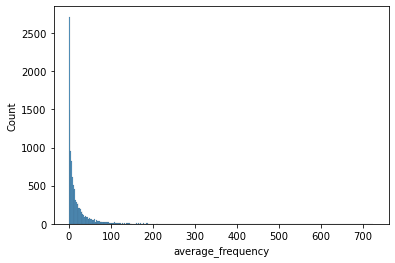

In [51]:
merchants_greaterthan1_transaction=merchant_clustering_df.loc[merchant_clustering_df['number_of_transactions']>1]
merchant_morethan1day_transaction=merchants_greaterthan1_transaction.loc[merchants_greaterthan1_transaction['average_frequency']>0.0]

sns.histplot(data=merchant_morethan1day_transaction, x="average_frequency")

In [69]:
# Finding outliers from data using data of merchants who have more than 1 transactions on minimum 2 different days
# We hypothesize this data would help us get a maximum value which we could use a threshold to mark a merchant as churned or not

lower_limit, upper_limit=determine_outlier_thresholds_iqr(merchant_morethan1day_transaction, "average_frequency")

print (lower_limit, upper_limit)
 
churn_interval=np.around(round(upper_limit/10)*10)
print (churn_interval)


-30.417151735305705 56.65029104118342
60


### Method 2: Use general market convention: Using 3 months here as churn interval. If merchant does not have transactions in last 3 months before 12/31/2024, we say it is churned

In [70]:
# Adding churn, last transaction date and amount for each merchant (Hypothesis being last transaction date and churn). 
churn_interval=90 

merchant_churn_df=preprocess_churnprediction_dataframe(transactions_cleaned_df, merchant_clustering_df, churn_interval)
print ("Percentage churn: ", sum(merchant_churn_df['churn'])/len(merchant_churn_df))

Processing progress:  0.0
Processing progress:  0.006968155529231412
Processing progress:  0.013936311058462825
Processing progress:  0.020904466587694237
Processing progress:  0.02787262211692565
Processing progress:  0.03484077764615706
Processing progress:  0.041808933175388474
Processing progress:  0.048777088704619886
Processing progress:  0.0557452442338513
Processing progress:  0.06271339976308271
Processing progress:  0.06968155529231412
Processing progress:  0.07664971082154554
Processing progress:  0.08361786635077695
Processing progress:  0.09058602188000836
Processing progress:  0.09755417740923977
Processing progress:  0.10452233293847119
Processing progress:  0.1114904884677026
Processing progress:  0.11845864399693401
Processing progress:  0.12542679952616542
Processing progress:  0.13239495505539683
Processing progress:  0.13936311058462825
Processing progress:  0.14633126611385966
Processing progress:  0.15329942164309107
Processing progress:  0.16026757717232248
Proce

Processing progress:  1.4075674169047454
Processing progress:  1.4145355724339768
Processing progress:  1.4215037279632081
Processing progress:  1.4284718834924395
Processing progress:  1.435440039021671
Processing progress:  1.4424081945509024
Processing progress:  1.4493763500801338
Processing progress:  1.4563445056093651
Processing progress:  1.4633126611385967
Processing progress:  1.470280816667828
Processing progress:  1.4772489721970594
Processing progress:  1.4842171277262908
Processing progress:  1.4911852832555224
Processing progress:  1.4981534387847537
Processing progress:  1.505121594313985
Processing progress:  1.5120897498432164
Processing progress:  1.519057905372448
Processing progress:  1.5260260609016794
Processing progress:  1.5329942164309107
Processing progress:  1.539962371960142
Processing progress:  1.5469305274893737
Processing progress:  1.553898683018605
Processing progress:  1.5608668385478364
Processing progress:  1.5678349940770677
Processing progress:  

Processing progress:  2.8290711448679535
Processing progress:  2.836039300397185
Processing progress:  2.8430074559264162
Processing progress:  2.8499756114556476
Processing progress:  2.856943766984879
Processing progress:  2.8639119225141103
Processing progress:  2.870880078043342
Processing progress:  2.8778482335725735
Processing progress:  2.884816389101805
Processing progress:  2.891784544631036
Processing progress:  2.8987527001602675
Processing progress:  2.905720855689499
Processing progress:  2.9126890112187303
Processing progress:  2.9196571667479616
Processing progress:  2.9266253222771934
Processing progress:  2.9335934778064248
Processing progress:  2.940561633335656
Processing progress:  2.9475297888648875
Processing progress:  2.954497944394119
Processing progress:  2.96146609992335
Processing progress:  2.9684342554525815
Processing progress:  2.975402410981813
Processing progress:  2.9823705665110447
Processing progress:  2.989338722040276
Processing progress:  2.9963

Processing progress:  4.2436067173019305
Processing progress:  4.250574872831161
Processing progress:  4.257543028360393
Processing progress:  4.264511183889624
Processing progress:  4.271479339418856
Processing progress:  4.278447494948087
Processing progress:  4.285415650477319
Processing progress:  4.2923838060065505
Processing progress:  4.299351961535781
Processing progress:  4.306320117065013
Processing progress:  4.313288272594244
Processing progress:  4.320256428123476
Processing progress:  4.327224583652707
Processing progress:  4.334192739181939
Processing progress:  4.34116089471117
Processing progress:  4.348129050240401
Processing progress:  4.355097205769633
Processing progress:  4.362065361298864
Processing progress:  4.369033516828096
Processing progress:  4.376001672357327
Processing progress:  4.3829698278865585
Processing progress:  4.3899379834157894
Processing progress:  4.396906138945021
Processing progress:  4.403874294474253
Processing progress:  4.4108424500034

Processing progress:  5.679046756323602
Processing progress:  5.6860149118528325
Processing progress:  5.692983067382064
Processing progress:  5.699951222911295
Processing progress:  5.706919378440527
Processing progress:  5.713887533969758
Processing progress:  5.72085568949899
Processing progress:  5.727823845028221
Processing progress:  5.734792000557452
Processing progress:  5.741760156086684
Processing progress:  5.748728311615915
Processing progress:  5.755696467145147
Processing progress:  5.762664622674378
Processing progress:  5.76963277820361
Processing progress:  5.776600933732841
Processing progress:  5.783569089262072
Processing progress:  5.790537244791304
Processing progress:  5.797505400320535
Processing progress:  5.804473555849767
Processing progress:  5.811441711378998
Processing progress:  5.81840986690823
Processing progress:  5.8253780224374605
Processing progress:  5.832346177966692
Processing progress:  5.839314333495923
Processing progress:  5.846282489025155
P

Processing progress:  7.107518639816041
Processing progress:  7.114486795345272
Processing progress:  7.1214549508745035
Processing progress:  7.128423106403735
Processing progress:  7.135391261932966
Processing progress:  7.142359417462198
Processing progress:  7.149327572991429
Processing progress:  7.156295728520661
Processing progress:  7.163263884049892
Processing progress:  7.1702320395791235
Processing progress:  7.177200195108354
Processing progress:  7.184168350637586
Processing progress:  7.191136506166818
Processing progress:  7.198104661696049
Processing progress:  7.205072817225281
Processing progress:  7.212040972754512
Processing progress:  7.219009128283743
Processing progress:  7.225977283812974
Processing progress:  7.232945439342206
Processing progress:  7.239913594871438
Processing progress:  7.246881750400669
Processing progress:  7.253849905929901
Processing progress:  7.260818061459132
Processing progress:  7.267786216988363
Processing progress:  7.27475437251759

Processing progress:  8.542958678837712
Processing progress:  8.549926834366943
Processing progress:  8.556894989896174
Processing progress:  8.563863145425406
Processing progress:  8.570831300954637
Processing progress:  8.577799456483868
Processing progress:  8.584767612013101
Processing progress:  8.591735767542332
Processing progress:  8.598703923071563
Processing progress:  8.605672078600794
Processing progress:  8.612640234130026
Processing progress:  8.619608389659257
Processing progress:  8.626576545188488
Processing progress:  8.63354470071772
Processing progress:  8.640512856246952
Processing progress:  8.647481011776183
Processing progress:  8.654449167305414
Processing progress:  8.661417322834646
Processing progress:  8.668385478363877
Processing progress:  8.675353633893108
Processing progress:  8.68232178942234
Processing progress:  8.689289944951572
Processing progress:  8.696258100480803
Processing progress:  8.703226256010034
Processing progress:  8.710194411539266
Pr

Processing progress:  9.985366873388614
Processing progress:  9.992335028917845
Processing progress:  9.999303184447077
Processing progress:  10.006271339976308
Processing progress:  10.01323949550554
Processing progress:  10.020207651034772
Processing progress:  10.027175806564003
Processing progress:  10.034143962093234
Processing progress:  10.041112117622465
Processing progress:  10.048080273151697
Processing progress:  10.055048428680928
Processing progress:  10.06201658421016
Processing progress:  10.06898473973939
Processing progress:  10.075952895268623
Processing progress:  10.082921050797854
Processing progress:  10.089889206327085
Processing progress:  10.096857361856317
Processing progress:  10.103825517385548
Processing progress:  10.11079367291478
Processing progress:  10.11776182844401
Processing progress:  10.124729983973243
Processing progress:  10.131698139502474
Processing progress:  10.138666295031705
Processing progress:  10.145634450560937
Processing progress:  10

Processing progress:  11.39293429029336
Processing progress:  11.39990244582259
Processing progress:  11.406870601351821
Processing progress:  11.413838756881054
Processing progress:  11.420806912410285
Processing progress:  11.427775067939516
Processing progress:  11.434743223468748
Processing progress:  11.44171137899798
Processing progress:  11.44867953452721
Processing progress:  11.455647690056441
Processing progress:  11.462615845585674
Processing progress:  11.469584001114905
Processing progress:  11.476552156644136
Processing progress:  11.483520312173368
Processing progress:  11.4904884677026
Processing progress:  11.49745662323183
Processing progress:  11.504424778761061
Processing progress:  11.511392934290294
Processing progress:  11.518361089819525
Processing progress:  11.525329245348756
Processing progress:  11.532297400877988
Processing progress:  11.53926555640722
Processing progress:  11.54623371193645
Processing progress:  11.553201867465681
Processing progress:  11.

Processing progress:  12.814438018256567
Processing progress:  12.8214061737858
Processing progress:  12.82837432931503
Processing progress:  12.835342484844261
Processing progress:  12.842310640373492
Processing progress:  12.849278795902725
Processing progress:  12.856246951431956
Processing progress:  12.863215106961187
Processing progress:  12.87018326249042
Processing progress:  12.87715141801965
Processing progress:  12.884119573548881
Processing progress:  12.891087729078112
Processing progress:  12.898055884607345
Processing progress:  12.905024040136576
Processing progress:  12.911992195665807
Processing progress:  12.91896035119504
Processing progress:  12.92592850672427
Processing progress:  12.932896662253501
Processing progress:  12.939864817782732
Processing progress:  12.946832973311965
Processing progress:  12.953801128841196
Processing progress:  12.960769284370427
Processing progress:  12.96773743989966
Processing progress:  12.97470559542889
Processing progress:  12.

Processing progress:  14.215037279632082
Processing progress:  14.222005435161313
Processing progress:  14.228973590690543
Processing progress:  14.235941746219776
Processing progress:  14.242909901749007
Processing progress:  14.249878057278238
Processing progress:  14.25684621280747
Processing progress:  14.263814368336702
Processing progress:  14.270782523865932
Processing progress:  14.277750679395163
Processing progress:  14.284718834924396
Processing progress:  14.291686990453627
Processing progress:  14.298655145982858
Processing progress:  14.30562330151209
Processing progress:  14.312591457041322
Processing progress:  14.319559612570552
Processing progress:  14.326527768099783
Processing progress:  14.333495923629016
Processing progress:  14.340464079158247
Processing progress:  14.347432234687478
Processing progress:  14.354400390216709
Processing progress:  14.361368545745941
Processing progress:  14.368336701275172
Processing progress:  14.375304856804403
Processing progres

Processing progress:  15.615636541007595
Processing progress:  15.622604696536827
Processing progress:  15.629572852066058
Processing progress:  15.636541007595289
Processing progress:  15.643509163124522
Processing progress:  15.650477318653753
Processing progress:  15.657445474182984
Processing progress:  15.664413629712215
Processing progress:  15.671381785241447
Processing progress:  15.678349940770678
Processing progress:  15.685318096299909
Processing progress:  15.69228625182914
Processing progress:  15.699254407358373
Processing progress:  15.706222562887604
Processing progress:  15.713190718416834
Processing progress:  15.720158873946067
Processing progress:  15.727127029475298
Processing progress:  15.734095185004529
Processing progress:  15.74106334053376
Processing progress:  15.748031496062993
Processing progress:  15.754999651592223
Processing progress:  15.761967807121454
Processing progress:  15.768935962650687
Processing progress:  15.775904118179918
Processing progres

Processing progress:  17.030172113441573
Processing progress:  17.037140268970802
Processing progress:  17.044108424500035
Processing progress:  17.051076580029267
Processing progress:  17.058044735558497
Processing progress:  17.06501289108773
Processing progress:  17.071981046616962
Processing progress:  17.07894920214619
Processing progress:  17.085917357675424
Processing progress:  17.092885513204656
Processing progress:  17.099853668733886
Processing progress:  17.10682182426312
Processing progress:  17.113789979792347
Processing progress:  17.12075813532158
Processing progress:  17.127726290850813
Processing progress:  17.134694446380042
Processing progress:  17.141662601909275
Processing progress:  17.148630757438507
Processing progress:  17.155598912967736
Processing progress:  17.16256706849697
Processing progress:  17.169535224026202
Processing progress:  17.17650337955543
Processing progress:  17.183471535084664
Processing progress:  17.190439690613893
Processing progress:  

Processing progress:  18.44470768587555
Processing progress:  18.45167584140478
Processing progress:  18.45864399693401
Processing progress:  18.465612152463244
Processing progress:  18.472580307992473
Processing progress:  18.479548463521706
Processing progress:  18.48651661905094
Processing progress:  18.493484774580168
Processing progress:  18.5004529301094
Processing progress:  18.507421085638633
Processing progress:  18.514389241167862
Processing progress:  18.521357396697095
Processing progress:  18.528325552226324
Processing progress:  18.535293707755557
Processing progress:  18.54226186328479
Processing progress:  18.54923001881402
Processing progress:  18.55619817434325
Processing progress:  18.563166329872484
Processing progress:  18.570134485401713
Processing progress:  18.577102640930946
Processing progress:  18.58407079646018
Processing progress:  18.591038951989407
Processing progress:  18.59800710751864
Processing progress:  18.604975263047873
Processing progress:  18.61

Processing progress:  19.852275102780293
Processing progress:  19.859243258309526
Processing progress:  19.866211413838755
Processing progress:  19.873179569367988
Processing progress:  19.88014772489722
Processing progress:  19.88711588042645
Processing progress:  19.894084035955682
Processing progress:  19.901052191484915
Processing progress:  19.908020347014144
Processing progress:  19.914988502543377
Processing progress:  19.92195665807261
Processing progress:  19.92892481360184
Processing progress:  19.93589296913107
Processing progress:  19.942861124660304
Processing progress:  19.949829280189533
Processing progress:  19.956797435718766
Processing progress:  19.963765591247995
Processing progress:  19.970733746777228
Processing progress:  19.97770190230646
Processing progress:  19.98467005783569
Processing progress:  19.991638213364922
Processing progress:  19.998606368894155
Processing progress:  20.005574524423384
Processing progress:  20.012542679952617
Processing progress:  2

Processing progress:  21.25984251968504
Processing progress:  21.26681067521427
Processing progress:  21.273778830743503
Processing progress:  21.280746986272735
Processing progress:  21.287715141801964
Processing progress:  21.294683297331197
Processing progress:  21.301651452860426
Processing progress:  21.30861960838966
Processing progress:  21.31558776391889
Processing progress:  21.32255591944812
Processing progress:  21.329524074977353
Processing progress:  21.336492230506586
Processing progress:  21.343460386035815
Processing progress:  21.350428541565048
Processing progress:  21.35739669709428
Processing progress:  21.36436485262351
Processing progress:  21.371333008152742
Processing progress:  21.378301163681975
Processing progress:  21.385269319211204
Processing progress:  21.392237474740437
Processing progress:  21.399205630269666
Processing progress:  21.4061737857989
Processing progress:  21.41314194132813
Processing progress:  21.42011009685736
Processing progress:  21.42

Processing progress:  22.681346247648246
Processing progress:  22.68831440317748
Processing progress:  22.69528255870671
Processing progress:  22.70225071423594
Processing progress:  22.709218869765174
Processing progress:  22.716187025294406
Processing progress:  22.723155180823635
Processing progress:  22.730123336352868
Processing progress:  22.737091491882097
Processing progress:  22.74405964741133
Processing progress:  22.751027802940563
Processing progress:  22.75799595846979
Processing progress:  22.764964113999024
Processing progress:  22.771932269528257
Processing progress:  22.778900425057486
Processing progress:  22.78586858058672
Processing progress:  22.79283673611595
Processing progress:  22.79980489164518
Processing progress:  22.806773047174413
Processing progress:  22.813741202703643
Processing progress:  22.820709358232875
Processing progress:  22.827677513762108
Processing progress:  22.834645669291337
Processing progress:  22.84161382482057
Processing progress:  22.

Processing progress:  24.102849975611456
Processing progress:  24.10981813114069
Processing progress:  24.116786286669917
Processing progress:  24.12375444219915
Processing progress:  24.130722597728383
Processing progress:  24.137690753257612
Processing progress:  24.144658908786845
Processing progress:  24.151627064316077
Processing progress:  24.158595219845306
Processing progress:  24.16556337537454
Processing progress:  24.17253153090377
Processing progress:  24.179499686433
Processing progress:  24.186467841962234
Processing progress:  24.193435997491463
Processing progress:  24.200404153020695
Processing progress:  24.207372308549928
Processing progress:  24.214340464079157
Processing progress:  24.22130861960839
Processing progress:  24.228276775137623
Processing progress:  24.235244930666852
Processing progress:  24.242213086196085
Processing progress:  24.249181241725314
Processing progress:  24.256149397254546
Processing progress:  24.26311755278378
Processing progress:  24.

Processing progress:  25.517385548045432
Processing progress:  25.524353703574665
Processing progress:  25.531321859103894
Processing progress:  25.538290014633127
Processing progress:  25.54525817016236
Processing progress:  25.55222632569159
Processing progress:  25.55919448122082
Processing progress:  25.566162636750054
Processing progress:  25.573130792279283
Processing progress:  25.580098947808516
Processing progress:  25.587067103337745
Processing progress:  25.594035258866978
Processing progress:  25.60100341439621
Processing progress:  25.60797156992544
Processing progress:  25.614939725454672
Processing progress:  25.621907880983905
Processing progress:  25.628876036513134
Processing progress:  25.635844192042367
Processing progress:  25.6428123475716
Processing progress:  25.64978050310083
Processing progress:  25.65674865863006
Processing progress:  25.663716814159294
Processing progress:  25.670684969688523
Processing progress:  25.677653125217756
Processing progress:  25.

Processing progress:  26.924952964950176
Processing progress:  26.93192112047941
Processing progress:  26.93888927600864
Processing progress:  26.94585743153787
Processing progress:  26.952825587067103
Processing progress:  26.959793742596336
Processing progress:  26.966761898125565
Processing progress:  26.973730053654798
Processing progress:  26.98069820918403
Processing progress:  26.98766636471326
Processing progress:  26.994634520242492
Processing progress:  27.001602675771725
Processing progress:  27.008570831300954
Processing progress:  27.015538986830187
Processing progress:  27.022507142359416
Processing progress:  27.02947529788865
Processing progress:  27.03644345341788
Processing progress:  27.04341160894711
Processing progress:  27.050379764476343
Processing progress:  27.057347920005576
Processing progress:  27.064316075534805
Processing progress:  27.071284231064038
Processing progress:  27.07825238659327
Processing progress:  27.0852205421225
Processing progress:  27.09

Processing progress:  28.346456692913385
Processing progress:  28.353424848442618
Processing progress:  28.360393003971847
Processing progress:  28.36736115950108
Processing progress:  28.374329315030312
Processing progress:  28.38129747055954
Processing progress:  28.388265626088774
Processing progress:  28.395233781618007
Processing progress:  28.402201937147236
Processing progress:  28.40917009267647
Processing progress:  28.4161382482057
Processing progress:  28.42310640373493
Processing progress:  28.430074559264163
Processing progress:  28.437042714793396
Processing progress:  28.444010870322625
Processing progress:  28.450979025851858
Processing progress:  28.457947181381087
Processing progress:  28.46491533691032
Processing progress:  28.471883492439552
Processing progress:  28.47885164796878
Processing progress:  28.485819803498014
Processing progress:  28.492787959027247
Processing progress:  28.499756114556476
Processing progress:  28.50672427008571
Processing progress:  28.

Processing progress:  29.754024109818133
Processing progress:  29.76099226534736
Processing progress:  29.767960420876594
Processing progress:  29.774928576405827
Processing progress:  29.781896731935056
Processing progress:  29.78886488746429
Processing progress:  29.795833042993518
Processing progress:  29.80280119852275
Processing progress:  29.809769354051983
Processing progress:  29.816737509581213
Processing progress:  29.823705665110445
Processing progress:  29.830673820639678
Processing progress:  29.837641976168907
Processing progress:  29.84461013169814
Processing progress:  29.851578287227372
Processing progress:  29.8585464427566
Processing progress:  29.865514598285834
Processing progress:  29.872482753815063
Processing progress:  29.879450909344296
Processing progress:  29.88641906487353
Processing progress:  29.893387220402758
Processing progress:  29.90035537593199
Processing progress:  29.907323531461223
Processing progress:  29.914291686990452
Processing progress:  29

Processing progress:  31.161591526722876
Processing progress:  31.16855968225211
Processing progress:  31.17552783778134
Processing progress:  31.18249599331057
Processing progress:  31.189464148839804
Processing progress:  31.196432304369033
Processing progress:  31.203400459898265
Processing progress:  31.210368615427495
Processing progress:  31.217336770956727
Processing progress:  31.22430492648596
Processing progress:  31.23127308201519
Processing progress:  31.238241237544422
Processing progress:  31.245209393073655
Processing progress:  31.252177548602884
Processing progress:  31.259145704132116
Processing progress:  31.26611385966135
Processing progress:  31.273082015190578
Processing progress:  31.28005017071981
Processing progress:  31.287018326249044
Processing progress:  31.293986481778273
Processing progress:  31.300954637307505
Processing progress:  31.307922792836735
Processing progress:  31.314890948365967
Processing progress:  31.3218591038952
Processing progress:  31.

Processing progress:  32.583095254686086
Processing progress:  32.590063410215315
Processing progress:  32.597031565744544
Processing progress:  32.60399972127378
Processing progress:  32.61096787680301
Processing progress:  32.61793603233224
Processing progress:  32.624904187861475
Processing progress:  32.631872343390704
Processing progress:  32.63884049891993
Processing progress:  32.64580865444917
Processing progress:  32.6527768099784
Processing progress:  32.65974496550763
Processing progress:  32.666713121036864
Processing progress:  32.67368127656609
Processing progress:  32.68064943209532
Processing progress:  32.68761758762456
Processing progress:  32.69458574315379
Processing progress:  32.70155389868302
Processing progress:  32.70852205421225
Processing progress:  32.71549020974148
Processing progress:  32.72245836527071
Processing progress:  32.72942652079995
Processing progress:  32.736394676329176
Processing progress:  32.743362831858406
Processing progress:  32.75033098

Processing progress:  34.00459898264929
Processing progress:  34.01156713817853
Processing progress:  34.01853529370776
Processing progress:  34.025503449236986
Processing progress:  34.032471604766215
Processing progress:  34.03943976029545
Processing progress:  34.04640791582468
Processing progress:  34.05337607135391
Processing progress:  34.060344226883146
Processing progress:  34.067312382412375
Processing progress:  34.074280537941604
Processing progress:  34.08124869347084
Processing progress:  34.08821684900007
Processing progress:  34.0951850045293
Processing progress:  34.102153160058535
Processing progress:  34.109121315587764
Processing progress:  34.11608947111699
Processing progress:  34.12305762664623
Processing progress:  34.13002578217546
Processing progress:  34.13699393770469
Processing progress:  34.143962093233924
Processing progress:  34.15093024876315
Processing progress:  34.15789840429238
Processing progress:  34.16486655982162
Processing progress:  34.17183471

Processing progress:  35.44003902167096
Processing progress:  35.44700717720019
Processing progress:  35.45397533272943
Processing progress:  35.46094348825866
Processing progress:  35.467911643787886
Processing progress:  35.47487979931712
Processing progress:  35.48184795484635
Processing progress:  35.48881611037558
Processing progress:  35.49578426590482
Processing progress:  35.502752421434046
Processing progress:  35.509720576963275
Processing progress:  35.51668873249251
Processing progress:  35.52365688802174
Processing progress:  35.53062504355097
Processing progress:  35.537593199080206
Processing progress:  35.544561354609435
Processing progress:  35.551529510138664
Processing progress:  35.5584976656679
Processing progress:  35.56546582119713
Processing progress:  35.57243397672636
Processing progress:  35.579402132255595
Processing progress:  35.586370287784824
Processing progress:  35.59333844331405
Processing progress:  35.60030659884329
Processing progress:  35.60727475

Processing progress:  36.87547906069263
Processing progress:  36.88244721622186
Processing progress:  36.8894153717511
Processing progress:  36.89638352728033
Processing progress:  36.90335168280956
Processing progress:  36.91031983833879
Processing progress:  36.91728799386802
Processing progress:  36.92425614939725
Processing progress:  36.93122430492649
Processing progress:  36.93819246045572
Processing progress:  36.945160615984946
Processing progress:  36.95212877151418
Processing progress:  36.95909692704341
Processing progress:  36.96606508257264
Processing progress:  36.97303323810188
Processing progress:  36.980001393631106
Processing progress:  36.986969549160335
Processing progress:  36.99393770468957
Processing progress:  37.0009058602188
Processing progress:  37.00787401574803
Processing progress:  37.014842171277266
Processing progress:  37.021810326806495
Processing progress:  37.028778482335724
Processing progress:  37.03574663786496
Processing progress:  37.04271479339

Processing progress:  38.296982788655846
Processing progress:  38.303950944185075
Processing progress:  38.310919099714305
Processing progress:  38.317887255243534
Processing progress:  38.32485541077277
Processing progress:  38.331823566302
Processing progress:  38.33879172183123
Processing progress:  38.345759877360464
Processing progress:  38.352728032889694
Processing progress:  38.35969618841892
Processing progress:  38.36666434394816
Processing progress:  38.37363249947739
Processing progress:  38.38060065500662
Processing progress:  38.38756881053585
Processing progress:  38.39453696606508
Processing progress:  38.40150512159431
Processing progress:  38.40847327712355
Processing progress:  38.41544143265278
Processing progress:  38.422409588182006
Processing progress:  38.42937774371124
Processing progress:  38.43634589924047
Processing progress:  38.4433140547697
Processing progress:  38.45028221029894
Processing progress:  38.457250365828166
Processing progress:  38.4642185213

Processing progress:  39.72545467214828
Processing progress:  39.73242282767751
Processing progress:  39.73939098320675
Processing progress:  39.746359138735976
Processing progress:  39.753327294265205
Processing progress:  39.76029544979444
Processing progress:  39.76726360532367
Processing progress:  39.7742317608529
Processing progress:  39.781199916382135
Processing progress:  39.788168071911365
Processing progress:  39.795136227440594
Processing progress:  39.80210438296983
Processing progress:  39.80907253849906
Processing progress:  39.81604069402829
Processing progress:  39.823008849557525
Processing progress:  39.829977005086754
Processing progress:  39.83694516061598
Processing progress:  39.84391331614522
Processing progress:  39.85088147167445
Processing progress:  39.85784962720368
Processing progress:  39.86481778273291
Processing progress:  39.87178593826214
Processing progress:  39.87875409379137
Processing progress:  39.88572224932061
Processing progress:  39.892690404

Processing progress:  41.16089471116995
Processing progress:  41.16786286669918
Processing progress:  41.17483102222842
Processing progress:  41.18179917775765
Processing progress:  41.188767333286876
Processing progress:  41.19573548881611
Processing progress:  41.20270364434534
Processing progress:  41.20967179987457
Processing progress:  41.21663995540381
Processing progress:  41.223608110933036
Processing progress:  41.230576266462265
Processing progress:  41.2375444219915
Processing progress:  41.24451257752073
Processing progress:  41.25148073304996
Processing progress:  41.258448888579196
Processing progress:  41.265417044108425
Processing progress:  41.272385199637654
Processing progress:  41.27935335516689
Processing progress:  41.28632151069612
Processing progress:  41.29328966622535
Processing progress:  41.300257821754585
Processing progress:  41.307225977283814
Processing progress:  41.31419413281304
Processing progress:  41.32116228834228
Processing progress:  41.32813044

Processing progress:  42.582398439133165
Processing progress:  42.589366594662394
Processing progress:  42.59633475019162
Processing progress:  42.60330290572085
Processing progress:  42.61027106125009
Processing progress:  42.61723921677932
Processing progress:  42.62420737230855
Processing progress:  42.63117552783778
Processing progress:  42.63814368336701
Processing progress:  42.64511183889624
Processing progress:  42.65207999442548
Processing progress:  42.65904814995471
Processing progress:  42.666016305483936
Processing progress:  42.67298446101317
Processing progress:  42.6799526165424
Processing progress:  42.68692077207163
Processing progress:  42.69388892760087
Processing progress:  42.700857083130096
Processing progress:  42.707825238659325
Processing progress:  42.71479339418856
Processing progress:  42.72176154971779
Processing progress:  42.72872970524702
Processing progress:  42.735697860776256
Processing progress:  42.742666016305485
Processing progress:  42.749634171

Processing progress:  44.0108703226256
Processing progress:  44.017838478154836
Processing progress:  44.024806633684065
Processing progress:  44.031774789213294
Processing progress:  44.03874294474252
Processing progress:  44.04571110027176
Processing progress:  44.05267925580099
Processing progress:  44.05964741133022
Processing progress:  44.066615566859454
Processing progress:  44.07358372238868
Processing progress:  44.08055187791791
Processing progress:  44.08752003344715
Processing progress:  44.09448818897638
Processing progress:  44.10145634450561
Processing progress:  44.10842450003484
Processing progress:  44.11539265556407
Processing progress:  44.1223608110933
Processing progress:  44.12932896662254
Processing progress:  44.13629712215177
Processing progress:  44.143265277680996
Processing progress:  44.15023343321023
Processing progress:  44.15720158873946
Processing progress:  44.16416974426869
Processing progress:  44.17113789979793
Processing progress:  44.178106055327

Processing progress:  45.44631036164727
Processing progress:  45.4532785171765
Processing progress:  45.460246672705736
Processing progress:  45.467214828234965
Processing progress:  45.474182983764194
Processing progress:  45.48115113929343
Processing progress:  45.48811929482266
Processing progress:  45.49508745035189
Processing progress:  45.502055605881125
Processing progress:  45.509023761410354
Processing progress:  45.51599191693958
Processing progress:  45.52296007246882
Processing progress:  45.52992822799805
Processing progress:  45.53689638352728
Processing progress:  45.543864539056514
Processing progress:  45.55083269458574
Processing progress:  45.55780085011497
Processing progress:  45.56476900564421
Processing progress:  45.57173716117344
Processing progress:  45.57870531670267
Processing progress:  45.5856734722319
Processing progress:  45.59264162776113
Processing progress:  45.59960978329036
Processing progress:  45.6065779388196
Processing progress:  45.613546094348

Processing progress:  46.87478224513971
Processing progress:  46.88175040066894
Processing progress:  46.88871855619817
Processing progress:  46.89568671172741
Processing progress:  46.902654867256636
Processing progress:  46.909623022785865
Processing progress:  46.9165911783151
Processing progress:  46.92355933384433
Processing progress:  46.93052748937356
Processing progress:  46.937495644902796
Processing progress:  46.944463800432025
Processing progress:  46.951431955961255
Processing progress:  46.95840011149049
Processing progress:  46.96536826701972
Processing progress:  46.97233642254895
Processing progress:  46.979304578078185
Processing progress:  46.986272733607414
Processing progress:  46.99324088913664
Processing progress:  47.00020904466588
Processing progress:  47.00717720019511
Processing progress:  47.01414535572434
Processing progress:  47.021113511253574
Processing progress:  47.0280816667828
Processing progress:  47.03504982231203
Processing progress:  47.042017977

Processing progress:  48.310222284161384
Processing progress:  48.31719043969061
Processing progress:  48.32415859521984
Processing progress:  48.33112675074908
Processing progress:  48.33809490627831
Processing progress:  48.34506306180754
Processing progress:  48.35203121733677
Processing progress:  48.358999372866
Processing progress:  48.36596752839523
Processing progress:  48.37293568392447
Processing progress:  48.379903839453696
Processing progress:  48.386871994982926
Processing progress:  48.39384015051216
Processing progress:  48.40080830604139
Processing progress:  48.40777646157062
Processing progress:  48.414744617099856
Processing progress:  48.421712772629085
Processing progress:  48.428680928158315
Processing progress:  48.43564908368755
Processing progress:  48.44261723921678
Processing progress:  48.44958539474601
Processing progress:  48.456553550275245
Processing progress:  48.463521705804474
Processing progress:  48.470489861333704
Processing progress:  48.47745801

Processing progress:  49.73869416765382
Processing progress:  49.745662323183055
Processing progress:  49.752630478712284
Processing progress:  49.75959863424151
Processing progress:  49.76656678977075
Processing progress:  49.77353494529998
Processing progress:  49.78050310082921
Processing progress:  49.787471256358444
Processing progress:  49.79443941188767
Processing progress:  49.8014075674169
Processing progress:  49.80837572294614
Processing progress:  49.81534387847537
Processing progress:  49.8223120340046
Processing progress:  49.82928018953383
Processing progress:  49.83624834506306
Processing progress:  49.84321650059229
Processing progress:  49.85018465612153
Processing progress:  49.85715281165076
Processing progress:  49.864120967179986
Processing progress:  49.87108912270922
Processing progress:  49.87805727823845
Processing progress:  49.88502543376768
Processing progress:  49.891993589296916
Processing progress:  49.898961744826146
Processing progress:  49.90592990035

Processing progress:  51.17413420667549
Processing progress:  51.181102362204726
Processing progress:  51.188070517733955
Processing progress:  51.195038673263184
Processing progress:  51.20200682879242
Processing progress:  51.20897498432165
Processing progress:  51.21594313985088
Processing progress:  51.222911295380115
Processing progress:  51.229879450909344
Processing progress:  51.23684760643857
Processing progress:  51.24381576196781
Processing progress:  51.25078391749704
Processing progress:  51.25775207302627
Processing progress:  51.264720228555504
Processing progress:  51.27168838408473
Processing progress:  51.27865653961396
Processing progress:  51.2856246951432
Processing progress:  51.29259285067243
Processing progress:  51.29956100620166
Processing progress:  51.30652916173089
Processing progress:  51.31349731726012
Processing progress:  51.32046547278935
Processing progress:  51.32743362831859
Processing progress:  51.33440178384782
Processing progress:  51.3413699393

Processing progress:  52.60260609016793
Processing progress:  52.60957424569716
Processing progress:  52.6165424012264
Processing progress:  52.623510556755626
Processing progress:  52.630478712284855
Processing progress:  52.63744686781409
Processing progress:  52.64441502334332
Processing progress:  52.65138317887255
Processing progress:  52.658351334401786
Processing progress:  52.665319489931015
Processing progress:  52.672287645460244
Processing progress:  52.67925580098948
Processing progress:  52.68622395651871
Processing progress:  52.69319211204794
Processing progress:  52.700160267577175
Processing progress:  52.707128423106404
Processing progress:  52.71409657863563
Processing progress:  52.72106473416487
Processing progress:  52.7280328896941
Processing progress:  52.73500104522333
Processing progress:  52.741969200752564
Processing progress:  52.74893735628179
Processing progress:  52.75590551181102
Processing progress:  52.76287366734026
Processing progress:  52.769841822

Processing progress:  54.02410981813114
Processing progress:  54.03107797366037
Processing progress:  54.0380461291896
Processing progress:  54.04501428471883
Processing progress:  54.05198244024807
Processing progress:  54.0589505957773
Processing progress:  54.065918751306526
Processing progress:  54.07288690683576
Processing progress:  54.07985506236499
Processing progress:  54.08682321789422
Processing progress:  54.09379137342346
Processing progress:  54.100759528952686
Processing progress:  54.107727684481915
Processing progress:  54.11469584001115
Processing progress:  54.12166399554038
Processing progress:  54.12863215106961
Processing progress:  54.135600306598846
Processing progress:  54.142568462128075
Processing progress:  54.149536617657304
Processing progress:  54.15650477318654
Processing progress:  54.16347292871577
Processing progress:  54.170441084245
Processing progress:  54.177409239774235
Processing progress:  54.184377395303464
Processing progress:  54.19134555083

Processing progress:  55.44561354609435
Processing progress:  55.45258170162358
Processing progress:  55.45954985715281
Processing progress:  55.466518012682045
Processing progress:  55.473486168211274
Processing progress:  55.4804543237405
Processing progress:  55.48742247926974
Processing progress:  55.49439063479897
Processing progress:  55.5013587903282
Processing progress:  55.50832694585743
Processing progress:  55.51529510138666
Processing progress:  55.52226325691589
Processing progress:  55.52923141244513
Processing progress:  55.53619956797436
Processing progress:  55.543167723503586
Processing progress:  55.55013587903282
Processing progress:  55.55710403456205
Processing progress:  55.56407219009128
Processing progress:  55.57104034562052
Processing progress:  55.578008501149746
Processing progress:  55.584976656678975
Processing progress:  55.59194481220821
Processing progress:  55.59891296773744
Processing progress:  55.60588112326667
Processing progress:  55.612849278795

Processing progress:  56.867117274057556
Processing progress:  56.87408542958679
Processing progress:  56.88105358511602
Processing progress:  56.88802174064525
Processing progress:  56.89498989617448
Processing progress:  56.901958051703716
Processing progress:  56.908926207232945
Processing progress:  56.915894362762174
Processing progress:  56.92286251829141
Processing progress:  56.92983067382064
Processing progress:  56.93679882934987
Processing progress:  56.943766984879105
Processing progress:  56.950735140408334
Processing progress:  56.95770329593756
Processing progress:  56.9646714514668
Processing progress:  56.97163960699603
Processing progress:  56.97860776252526
Processing progress:  56.985575918054494
Processing progress:  56.99254407358372
Processing progress:  56.99951222911295
Processing progress:  57.00648038464219
Processing progress:  57.01344854017142
Processing progress:  57.020416695700646
Processing progress:  57.02738485122988
Processing progress:  57.03435300

Processing progress:  58.30255731307923
Processing progress:  58.309525468608456
Processing progress:  58.31649362413769
Processing progress:  58.32346177966692
Processing progress:  58.33042993519615
Processing progress:  58.33739809072539
Processing progress:  58.344366246254616
Processing progress:  58.351334401783845
Processing progress:  58.35830255731308
Processing progress:  58.36527071284231
Processing progress:  58.37223886837154
Processing progress:  58.379207023900776
Processing progress:  58.386175179430005
Processing progress:  58.393143334959234
Processing progress:  58.40011149048847
Processing progress:  58.4070796460177
Processing progress:  58.41404780154693
Processing progress:  58.421015957076165
Processing progress:  58.427984112605394
Processing progress:  58.43495226813462
Processing progress:  58.44192042366386
Processing progress:  58.44888857919309
Processing progress:  58.45585673472232
Processing progress:  58.462824890251554
Processing progress:  58.4697930

Processing progress:  59.7379973521009
Processing progress:  59.74496550763013
Processing progress:  59.75193366315936
Processing progress:  59.75890181868859
Processing progress:  59.76586997421782
Processing progress:  59.77283812974706
Processing progress:  59.77980628527629
Processing progress:  59.786774440805516
Processing progress:  59.79374259633475
Processing progress:  59.80071075186398
Processing progress:  59.80767890739321
Processing progress:  59.81464706292245
Processing progress:  59.821615218451676
Processing progress:  59.828583373980905
Processing progress:  59.83555152951014
Processing progress:  59.84251968503937
Processing progress:  59.8494878405686
Processing progress:  59.856455996097836
Processing progress:  59.863424151627065
Processing progress:  59.870392307156294
Processing progress:  59.87736046268553
Processing progress:  59.88432861821476
Processing progress:  59.89129677374399
Processing progress:  59.898264929273225
Processing progress:  59.9052330848

Processing progress:  61.17343739112257
Processing progress:  61.1804055466518
Processing progress:  61.187373702181034
Processing progress:  61.19434185771026
Processing progress:  61.20131001323949
Processing progress:  61.20827816876873
Processing progress:  61.21524632429796
Processing progress:  61.22221447982719
Processing progress:  61.22918263535642
Processing progress:  61.23615079088565
Processing progress:  61.24311894641488
Processing progress:  61.25008710194412
Processing progress:  61.25705525747335
Processing progress:  61.264023413002576
Processing progress:  61.27099156853181
Processing progress:  61.27795972406104
Processing progress:  61.28492787959027
Processing progress:  61.29189603511951
Processing progress:  61.298864190648736
Processing progress:  61.305832346177965
Processing progress:  61.3128005017072
Processing progress:  61.31976865723643
Processing progress:  61.32673681276566
Processing progress:  61.333704968294896
Processing progress:  61.340673123824

Processing progress:  62.60190927461501
Processing progress:  62.60887743014424
Processing progress:  62.61584558567347
Processing progress:  62.622813741202705
Processing progress:  62.629781896731934
Processing progress:  62.63675005226116
Processing progress:  62.6437182077904
Processing progress:  62.65068636331963
Processing progress:  62.65765451884886
Processing progress:  62.664622674378094
Processing progress:  62.67159082990732
Processing progress:  62.67855898543655
Processing progress:  62.68552714096579
Processing progress:  62.69249529649502
Processing progress:  62.69946345202425
Processing progress:  62.70643160755348
Processing progress:  62.71339976308271
Processing progress:  62.72036791861194
Processing progress:  62.72733607414118
Processing progress:  62.73430422967041
Processing progress:  62.741272385199636
Processing progress:  62.74824054072887
Processing progress:  62.7552086962581
Processing progress:  62.76217685178733
Processing progress:  62.7691450073165

Processing progress:  64.02341300257822
Processing progress:  64.03038115810745
Processing progress:  64.03734931363668
Processing progress:  64.04431746916592
Processing progress:  64.05128562469514
Processing progress:  64.05825378022438
Processing progress:  64.06522193575361
Processing progress:  64.07219009128283
Processing progress:  64.07915824681207
Processing progress:  64.0861264023413
Processing progress:  64.09309455787053
Processing progress:  64.10006271339977
Processing progress:  64.107030868929
Processing progress:  64.11399902445822
Processing progress:  64.12096717998746
Processing progress:  64.12793533551668
Processing progress:  64.13490349104592
Processing progress:  64.14187164657515
Processing progress:  64.14883980210438
Processing progress:  64.15580795763361
Processing progress:  64.16277611316285
Processing progress:  64.16974426869207
Processing progress:  64.17671242422131
Processing progress:  64.18368057975054
Processing progress:  64.19064873527977
Pro

Processing progress:  65.47278935265835
Processing progress:  65.47975750818759
Processing progress:  65.48672566371681
Processing progress:  65.49369381924605
Processing progress:  65.50066197477528
Processing progress:  65.5076301303045
Processing progress:  65.51459828583374
Processing progress:  65.52156644136298
Processing progress:  65.5285345968922
Processing progress:  65.53550275242144
Processing progress:  65.54247090795066
Processing progress:  65.5494390634799
Processing progress:  65.55640721900913
Processing progress:  65.56337537453835
Processing progress:  65.57034353006759
Processing progress:  65.57731168559683
Processing progress:  65.58427984112605
Processing progress:  65.59124799665528
Processing progress:  65.59821615218452
Processing progress:  65.60518430771374
Processing progress:  65.61215246324298
Processing progress:  65.61912061877221
Processing progress:  65.62608877430144
Processing progress:  65.63305692983067
Processing progress:  65.64002508535991
Pro

Processing progress:  66.91519754720926
Processing progress:  66.92216570273848
Processing progress:  66.92913385826772
Processing progress:  66.93610201379695
Processing progress:  66.94307016932618
Processing progress:  66.95003832485541
Processing progress:  66.95700648038465
Processing progress:  66.96397463591387
Processing progress:  66.97094279144311
Processing progress:  66.97791094697233
Processing progress:  66.98487910250157
Processing progress:  66.9918472580308
Processing progress:  66.99881541356002
Processing progress:  67.00578356908926
Processing progress:  67.0127517246185
Processing progress:  67.01971988014772
Processing progress:  67.02668803567695
Processing progress:  67.03365619120619
Processing progress:  67.04062434673541
Processing progress:  67.04759250226465
Processing progress:  67.05456065779389
Processing progress:  67.06152881332311
Processing progress:  67.06849696885234
Processing progress:  67.07546512438158
Processing progress:  67.0824332799108
Pro

Processing progress:  68.35760574176015
Processing progress:  68.36457389728939
Processing progress:  68.37154205281863
Processing progress:  68.37851020834785
Processing progress:  68.38547836387708
Processing progress:  68.39244651940632
Processing progress:  68.39941467493554
Processing progress:  68.40638283046478
Processing progress:  68.413350985994
Processing progress:  68.42031914152324
Processing progress:  68.42728729705247
Processing progress:  68.4342554525817
Processing progress:  68.44122360811093
Processing progress:  68.44819176364017
Processing progress:  68.45515991916939
Processing progress:  68.46212807469863
Processing progress:  68.46909623022786
Processing progress:  68.47606438575708
Processing progress:  68.48303254128632
Processing progress:  68.49000069681556
Processing progress:  68.49696885234478
Processing progress:  68.50393700787401
Processing progress:  68.51090516340325
Processing progress:  68.51787331893247
Processing progress:  68.52484147446171
Pro

Processing progress:  69.80001393631106
Processing progress:  69.8069820918403
Processing progress:  69.81395024736952
Processing progress:  69.82091840289876
Processing progress:  69.82788655842798
Processing progress:  69.83485471395721
Processing progress:  69.84182286948645
Processing progress:  69.84879102501567
Processing progress:  69.85575918054491
Processing progress:  69.86272733607414
Processing progress:  69.86969549160337
Processing progress:  69.8766636471326
Processing progress:  69.88363180266184
Processing progress:  69.89059995819106
Processing progress:  69.8975681137203
Processing progress:  69.90453626924953
Processing progress:  69.91150442477876
Processing progress:  69.91847258030799
Processing progress:  69.92544073583723
Processing progress:  69.93240889136645
Processing progress:  69.93937704689569
Processing progress:  69.94634520242492
Processing progress:  69.95331335795414
Processing progress:  69.96028151348338
Processing progress:  69.96724966901262
Pro

Processing progress:  71.24939028639119
Processing progress:  71.25635844192043
Processing progress:  71.26332659744965
Processing progress:  71.27029475297888
Processing progress:  71.27726290850812
Processing progress:  71.28423106403734
Processing progress:  71.29119921956658
Processing progress:  71.29816737509582
Processing progress:  71.30513553062504
Processing progress:  71.31210368615427
Processing progress:  71.31907184168351
Processing progress:  71.32603999721273
Processing progress:  71.33300815274197
Processing progress:  71.3399763082712
Processing progress:  71.34694446380043
Processing progress:  71.35391261932966
Processing progress:  71.3608807748589
Processing progress:  71.36784893038812
Processing progress:  71.37481708591736
Processing progress:  71.3817852414466
Processing progress:  71.38875339697582
Processing progress:  71.39572155250505
Processing progress:  71.40268970803429
Processing progress:  71.40965786356351
Processing progress:  71.41662601909275
Pro

Processing progress:  72.6917984809421
Processing progress:  72.69876663647132
Processing progress:  72.70573479200056
Processing progress:  72.71270294752979
Processing progress:  72.71967110305901
Processing progress:  72.72663925858825
Processing progress:  72.73360741411749
Processing progress:  72.74057556964671
Processing progress:  72.74754372517594
Processing progress:  72.75451188070518
Processing progress:  72.7614800362344
Processing progress:  72.76844819176364
Processing progress:  72.77541634729288
Processing progress:  72.7823845028221
Processing progress:  72.78935265835133
Processing progress:  72.79632081388057
Processing progress:  72.80328896940979
Processing progress:  72.81025712493903
Processing progress:  72.81722528046826
Processing progress:  72.82419343599749
Processing progress:  72.83116159152672
Processing progress:  72.83812974705596
Processing progress:  72.84509790258518
Processing progress:  72.85206605811442
Processing progress:  72.85903421364365
Pro

Processing progress:  74.14117483102223
Processing progress:  74.14814298655146
Processing progress:  74.15511114208068
Processing progress:  74.16207929760992
Processing progress:  74.16904745313916
Processing progress:  74.17601560866838
Processing progress:  74.18298376419762
Processing progress:  74.18995191972685
Processing progress:  74.19692007525607
Processing progress:  74.20388823078531
Processing progress:  74.21085638631455
Processing progress:  74.21782454184377
Processing progress:  74.224792697373
Processing progress:  74.23176085290224
Processing progress:  74.23872900843146
Processing progress:  74.2456971639607
Processing progress:  74.25266531948994
Processing progress:  74.25963347501916
Processing progress:  74.2666016305484
Processing progress:  74.27356978607763
Processing progress:  74.28053794160685
Processing progress:  74.28750609713609
Processing progress:  74.29447425266532
Processing progress:  74.30144240819455
Processing progress:  74.30841056372378
Proc

Processing progress:  75.58358302557313
Processing progress:  75.59055118110236
Processing progress:  75.59751933663159
Processing progress:  75.60448749216083
Processing progress:  75.61145564769005
Processing progress:  75.61842380321929
Processing progress:  75.62539195874852
Processing progress:  75.63236011427774
Processing progress:  75.63932826980698
Processing progress:  75.64629642533622
Processing progress:  75.65326458086544
Processing progress:  75.66023273639468
Processing progress:  75.66720089192391
Processing progress:  75.67416904745313
Processing progress:  75.68113720298237
Processing progress:  75.6881053585116
Processing progress:  75.69507351404083
Processing progress:  75.70204166957006
Processing progress:  75.7090098250993
Processing progress:  75.71597798062852
Processing progress:  75.72294613615776
Processing progress:  75.729914291687
Processing progress:  75.73688244721622
Processing progress:  75.74385060274545
Processing progress:  75.75081875827469
Proc

Processing progress:  77.02599122012403
Processing progress:  77.03295937565326
Processing progress:  77.0399275311825
Processing progress:  77.04689568671172
Processing progress:  77.05386384224096
Processing progress:  77.0608319977702
Processing progress:  77.06780015329942
Processing progress:  77.07476830882865
Processing progress:  77.08173646435789
Processing progress:  77.08870461988711
Processing progress:  77.09567277541635
Processing progress:  77.10264093094558
Processing progress:  77.1096090864748
Processing progress:  77.11657724200404
Processing progress:  77.12354539753328
Processing progress:  77.1305135530625
Processing progress:  77.13748170859174
Processing progress:  77.14444986412097
Processing progress:  77.1514180196502
Processing progress:  77.15838617517943
Processing progress:  77.16535433070867
Processing progress:  77.17232248623789
Processing progress:  77.17929064176712
Processing progress:  77.18625879729636
Processing progress:  77.19322695282558
Proce

Processing progress:  78.47536757020417
Processing progress:  78.48233572573339
Processing progress:  78.48930388126263
Processing progress:  78.49627203679186
Processing progress:  78.50324019232109
Processing progress:  78.51020834785032
Processing progress:  78.51717650337956
Processing progress:  78.52414465890878
Processing progress:  78.53111281443802
Processing progress:  78.53808096996725
Processing progress:  78.54504912549648
Processing progress:  78.55201728102571
Processing progress:  78.55898543655495
Processing progress:  78.56595359208417
Processing progress:  78.5729217476134
Processing progress:  78.57988990314264
Processing progress:  78.58685805867187
Processing progress:  78.5938262142011
Processing progress:  78.60079436973034
Processing progress:  78.60776252525956
Processing progress:  78.6147306807888
Processing progress:  78.62169883631803
Processing progress:  78.62866699184725
Processing progress:  78.63563514737649
Processing progress:  78.64260330290573
Pro

Processing progress:  79.91080760922584
Processing progress:  79.91777576475506
Processing progress:  79.9247439202843
Processing progress:  79.93171207581354
Processing progress:  79.93868023134276
Processing progress:  79.945648386872
Processing progress:  79.95261654240123
Processing progress:  79.95958469793045
Processing progress:  79.96655285345969
Processing progress:  79.97352100898893
Processing progress:  79.98048916451815
Processing progress:  79.98745732004738
Processing progress:  79.99442547557662
Processing progress:  80.00139363110584
Processing progress:  80.00836178663508
Processing progress:  80.01532994216431
Processing progress:  80.02229809769354
Processing progress:  80.02926625322277
Processing progress:  80.03623440875201
Processing progress:  80.04320256428123
Processing progress:  80.05017071981047
Processing progress:  80.0571388753397
Processing progress:  80.06410703086893
Processing progress:  80.07107518639816
Processing progress:  80.0780433419274
Proce

Processing progress:  81.35321580377673
Processing progress:  81.36018395930597
Processing progress:  81.3671521148352
Processing progress:  81.37412027036443
Processing progress:  81.38108842589367
Processing progress:  81.3880565814229
Processing progress:  81.39502473695212
Processing progress:  81.40199289248136
Processing progress:  81.4089610480106
Processing progress:  81.41592920353982
Processing progress:  81.42289735906905
Processing progress:  81.42986551459829
Processing progress:  81.43683367012751
Processing progress:  81.44380182565675
Processing progress:  81.45076998118599
Processing progress:  81.45773813671521
Processing progress:  81.46470629224444
Processing progress:  81.47167444777368
Processing progress:  81.4786426033029
Processing progress:  81.48561075883214
Processing progress:  81.49257891436137
Processing progress:  81.4995470698906
Processing progress:  81.50651522541983
Processing progress:  81.51348338094907
Processing progress:  81.52045153647829
Proce

Processing progress:  82.79562399832764
Processing progress:  82.80259215385688
Processing progress:  82.8095603093861
Processing progress:  82.81652846491534
Processing progress:  82.82349662044457
Processing progress:  82.8304647759738
Processing progress:  82.83743293150303
Processing progress:  82.84440108703227
Processing progress:  82.85136924256149
Processing progress:  82.85833739809073
Processing progress:  82.86530555361996
Processing progress:  82.87227370914918
Processing progress:  82.87924186467842
Processing progress:  82.88621002020766
Processing progress:  82.89317817573688
Processing progress:  82.90014633126611
Processing progress:  82.90711448679535
Processing progress:  82.91408264232457
Processing progress:  82.92105079785381
Processing progress:  82.92801895338305
Processing progress:  82.93498710891227
Processing progress:  82.9419552644415
Processing progress:  82.94892341997074
Processing progress:  82.95589157549996
Processing progress:  82.9628597310292
Proc

Processing progress:  84.23106403734931
Processing progress:  84.23803219287855
Processing progress:  84.24500034840777
Processing progress:  84.25196850393701
Processing progress:  84.25893665946624
Processing progress:  84.26590481499547
Processing progress:  84.2728729705247
Processing progress:  84.27984112605394
Processing progress:  84.28680928158316
Processing progress:  84.2937774371124
Processing progress:  84.30074559264163
Processing progress:  84.30771374817085
Processing progress:  84.31468190370009
Processing progress:  84.32165005922933
Processing progress:  84.32861821475855
Processing progress:  84.33558637028779
Processing progress:  84.34255452581702
Processing progress:  84.34952268134624
Processing progress:  84.35649083687548
Processing progress:  84.36345899240472
Processing progress:  84.37042714793394
Processing progress:  84.37739530346317
Processing progress:  84.38436345899241
Processing progress:  84.39133161452163
Processing progress:  84.39829977005087
Pr

Processing progress:  85.66650407637098
Processing progress:  85.67347223190022
Processing progress:  85.68044038742944
Processing progress:  85.68740854295868
Processing progress:  85.69437669848791
Processing progress:  85.70134485401714
Processing progress:  85.70831300954637
Processing progress:  85.71528116507561
Processing progress:  85.72224932060483
Processing progress:  85.72921747613407
Processing progress:  85.7361856316633
Processing progress:  85.74315378719253
Processing progress:  85.75012194272176
Processing progress:  85.757090098251
Processing progress:  85.76405825378022
Processing progress:  85.77102640930946
Processing progress:  85.77799456483869
Processing progress:  85.78496272036791
Processing progress:  85.79193087589715
Processing progress:  85.79889903142639
Processing progress:  85.80586718695561
Processing progress:  85.81283534248485
Processing progress:  85.81980349801408
Processing progress:  85.8267716535433
Processing progress:  85.83373980907254
Proc

Processing progress:  87.10194411539266
Processing progress:  87.10891227092189
Processing progress:  87.11588042645111
Processing progress:  87.12284858198035
Processing progress:  87.12981673750959
Processing progress:  87.13678489303881
Processing progress:  87.14375304856804
Processing progress:  87.15072120409728
Processing progress:  87.1576893596265
Processing progress:  87.16465751515574
Processing progress:  87.17162567068497
Processing progress:  87.1785938262142
Processing progress:  87.18556198174343
Processing progress:  87.19253013727267
Processing progress:  87.19949829280189
Processing progress:  87.20646644833113
Processing progress:  87.21343460386036
Processing progress:  87.22040275938959
Processing progress:  87.22737091491882
Processing progress:  87.23433907044806
Processing progress:  87.24130722597728
Processing progress:  87.24827538150652
Processing progress:  87.25524353703575
Processing progress:  87.26221169256497
Processing progress:  87.26917984809421
Pr

Processing progress:  88.53738415441433
Processing progress:  88.54435230994356
Processing progress:  88.55132046547278
Processing progress:  88.55828862100202
Processing progress:  88.56525677653126
Processing progress:  88.57222493206048
Processing progress:  88.57919308758972
Processing progress:  88.58616124311895
Processing progress:  88.59312939864817
Processing progress:  88.60009755417741
Processing progress:  88.60706570970665
Processing progress:  88.61403386523587
Processing progress:  88.6210020207651
Processing progress:  88.62797017629434
Processing progress:  88.63493833182356
Processing progress:  88.6419064873528
Processing progress:  88.64887464288203
Processing progress:  88.65584279841126
Processing progress:  88.6628109539405
Processing progress:  88.66977910946973
Processing progress:  88.67674726499895
Processing progress:  88.68371542052819
Processing progress:  88.69068357605742
Processing progress:  88.69765173158665
Processing progress:  88.70461988711588
Pro

Processing progress:  89.972824193436
Processing progress:  89.97979234896523
Processing progress:  89.98676050449446
Processing progress:  89.99372866002369
Processing progress:  90.00069681555293
Processing progress:  90.00766497108215
Processing progress:  90.01463312661139
Processing progress:  90.02160128214062
Processing progress:  90.02856943766984
Processing progress:  90.03553759319908
Processing progress:  90.04250574872832
Processing progress:  90.04947390425754
Processing progress:  90.05644205978678
Processing progress:  90.06341021531601
Processing progress:  90.07037837084523
Processing progress:  90.07734652637447
Processing progress:  90.0843146819037
Processing progress:  90.09128283743293
Processing progress:  90.09825099296216
Processing progress:  90.1052191484914
Processing progress:  90.11218730402062
Processing progress:  90.11915545954986
Processing progress:  90.1261236150791
Processing progress:  90.13309177060832
Processing progress:  90.14005992613755
Proce

Processing progress:  91.42220054351613
Processing progress:  91.42916869904536
Processing progress:  91.4361368545746
Processing progress:  91.44310501010382
Processing progress:  91.45007316563306
Processing progress:  91.4570413211623
Processing progress:  91.46400947669152
Processing progress:  91.47097763222075
Processing progress:  91.47794578774999
Processing progress:  91.48491394327921
Processing progress:  91.49188209880845
Processing progress:  91.49885025433768
Processing progress:  91.5058184098669
Processing progress:  91.51278656539614
Processing progress:  91.51975472092538
Processing progress:  91.5267228764546
Processing progress:  91.53369103198384
Processing progress:  91.54065918751307
Processing progress:  91.5476273430423
Processing progress:  91.55459549857153
Processing progress:  91.56156365410077
Processing progress:  91.56853180962999
Processing progress:  91.57549996515922
Processing progress:  91.58246812068846
Processing progress:  91.58943627621768
Proce

Processing progress:  92.8576405825378
Processing progress:  92.86460873806703
Processing progress:  92.87157689359627
Processing progress:  92.87854504912549
Processing progress:  92.88551320465473
Processing progress:  92.89248136018396
Processing progress:  92.89944951571319
Processing progress:  92.90641767124242
Processing progress:  92.91338582677166
Processing progress:  92.92035398230088
Processing progress:  92.92732213783012
Processing progress:  92.93429029335935
Processing progress:  92.94125844888858
Processing progress:  92.94822660441781
Processing progress:  92.95519475994705
Processing progress:  92.96216291547627
Processing progress:  92.9691310710055
Processing progress:  92.97609922653474
Processing progress:  92.98306738206396
Processing progress:  92.9900355375932
Processing progress:  92.99700369312244
Processing progress:  93.00397184865166
Processing progress:  93.0109400041809
Processing progress:  93.01790815971013
Processing progress:  93.02487631523935
Proc

Processing progress:  94.29308062155947
Processing progress:  94.3000487770887
Processing progress:  94.30701693261794
Processing progress:  94.31398508814716
Processing progress:  94.3209532436764
Processing progress:  94.32792139920564
Processing progress:  94.33488955473486
Processing progress:  94.3418577102641
Processing progress:  94.34882586579333
Processing progress:  94.35579402132255
Processing progress:  94.36276217685179
Processing progress:  94.36973033238102
Processing progress:  94.37669848791025
Processing progress:  94.38366664343948
Processing progress:  94.39063479896872
Processing progress:  94.39760295449794
Processing progress:  94.40457111002718
Processing progress:  94.41153926555641
Processing progress:  94.41850742108564
Processing progress:  94.42547557661487
Processing progress:  94.43244373214411
Processing progress:  94.43941188767333
Processing progress:  94.44638004320257
Processing progress:  94.4533481987318
Processing progress:  94.46031635426102
Proc

Processing progress:  95.73548881611038
Processing progress:  95.74245697163961
Processing progress:  95.74942512716883
Processing progress:  95.75639328269807
Processing progress:  95.7633614382273
Processing progress:  95.77032959375653
Processing progress:  95.77729774928576
Processing progress:  95.784265904815
Processing progress:  95.79123406034422
Processing progress:  95.79820221587346
Processing progress:  95.8051703714027
Processing progress:  95.81213852693192
Processing progress:  95.81910668246115
Processing progress:  95.82607483799039
Processing progress:  95.83304299351961
Processing progress:  95.84001114904885
Processing progress:  95.84697930457808
Processing progress:  95.8539474601073
Processing progress:  95.86091561563654
Processing progress:  95.86788377116578
Processing progress:  95.874851926695
Processing progress:  95.88182008222424
Processing progress:  95.88878823775347
Processing progress:  95.8957563932827
Processing progress:  95.90272454881193
Processi

Processing progress:  97.1848651661905
Processing progress:  97.19183332171974
Processing progress:  97.19880147724898
Processing progress:  97.2057696327782
Processing progress:  97.21273778830744
Processing progress:  97.21970594383667
Processing progress:  97.2266740993659
Processing progress:  97.23364225489513
Processing progress:  97.24061041042437
Processing progress:  97.24757856595359
Processing progress:  97.25454672148282
Processing progress:  97.26151487701206
Processing progress:  97.26848303254128
Processing progress:  97.27545118807052
Processing progress:  97.28241934359976
Processing progress:  97.28938749912898
Processing progress:  97.29635565465821
Processing progress:  97.30332381018745
Processing progress:  97.31029196571667
Processing progress:  97.31726012124591
Processing progress:  97.32422827677513
Processing progress:  97.33119643230437
Processing progress:  97.3381645878336
Processing progress:  97.34513274336283
Processing progress:  97.35210089889206
Proc

Processing progress:  98.62030520521218
Processing progress:  98.62727336074141
Processing progress:  98.63424151627065
Processing progress:  98.64120967179987
Processing progress:  98.6481778273291
Processing progress:  98.65514598285834
Processing progress:  98.66211413838757
Processing progress:  98.6690822939168
Processing progress:  98.67605044944604
Processing progress:  98.68301860497526
Processing progress:  98.6899867605045
Processing progress:  98.69695491603373
Processing progress:  98.70392307156295
Processing progress:  98.71089122709219
Processing progress:  98.71785938262143
Processing progress:  98.72482753815065
Processing progress:  98.73179569367989
Processing progress:  98.73876384920912
Processing progress:  98.74573200473834
Processing progress:  98.75270016026758
Processing progress:  98.7596683157968
Processing progress:  98.76663647132604
Processing progress:  98.77360462685527
Processing progress:  98.7805727823845
Processing progress:  98.78754093791373
Proce

In [71]:
merchant_churn_df

,merchant,churn,last_transaction_date,last_transaction_amount,number_of_transactions,total_amount,average_frequency
0,0002b63b92,1,11664000.0,3379,1,3379,0
1,0002d07bba,0,61603200.0,2057,4,89278,21.666667
2,00057d4302,1,18576000.0,742,28,29521,2.444444
3,000bcff341,1,19008000.0,7826,1,7826,0
4,000ddbf0ca,1,13132800.0,10299,1,10299,0
...,...,...,...,...,...,...,...
14346,ffd3e45675,1,2246400.0,5398,5,72626,5.75
14347,ffe1f6b51a,1,35769600.0,6517,53,281616,5.0
14348,ffe26b900d,0,59529600.0,1492,81,959113,4.175
14349,ffec05edb9,1,35337600.0,5218,3,15934,10.0


### Question 1:  Using only the given data, how would you identify different kinds of businesses in the sample? Please generate assignments for each merchant.

In [ ]:
'''
Since this is a unsupervised tagging problem. We'll use k-means to generate assignments for each merchant.
We use the elbow method to determine the the number of clusters the data can be segmented into
'''

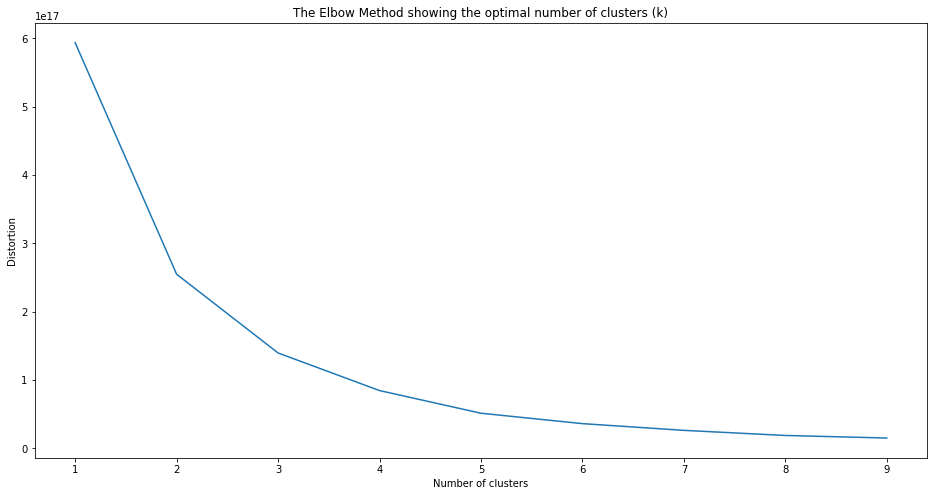

In [82]:
outputs = []
number_of_clusters = range(1,10)
for cluster in number_of_clusters:
    kmeanModel = KMeans(n_clusters=cluster, init = 'k-means++', random_state=42)
    kmeanModel.fit(merchant_clustering_df.drop(columns=['merchant'],axis=1))
    outputs.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(number_of_clusters, outputs)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters (k)')

plt.show()

In [83]:
# Building the model and assigning cluster IDs to each merchant

kmean = KMeans(n_clusters=4, init = 'k-means++', random_state=42)

kmean.fit(merchant_clustering_df.drop(columns=['merchant'],axis=1))
y_pred = kmean.predict(merchant_clustering_df.drop(columns=['merchant'],axis=1))
merchant_clustering_df['assigned_cluster'] = y_pred

In [84]:
# Visualizating the data with respect to the assigned clusters

fig = px.scatter_3d(merchant_clustering_df, x= merchant_clustering_df['number_of_transactions'], y= merchant_clustering_df['total_amount'],z = merchant_clustering_df['average_frequency'],
                  color=merchant_clustering_df['assigned_cluster'], labels={'x':'number_of_transactions', 'y':'total_amount','z':'average_frequency'} )
fig.show()

In [85]:
merchant_clustering_df

,merchant,number_of_transactions,total_amount,average_frequency,assigned_cluster
0,0002b63b92,1,3379,0,0
1,0002d07bba,4,89278,21.666667,0
2,00057d4302,28,29521,2.444444,0
3,000bcff341,1,7826,0,0
4,000ddbf0ca,1,10299,0,0
...,...,...,...,...,...
14346,ffd3e45675,5,72626,5.75,0
14347,ffe1f6b51a,53,281616,5.0,0
14348,ffe26b900d,81,959113,4.175,0
14349,ffec05edb9,3,15934,10.0,0


In [86]:
merchant_clustering_df['assigned_cluster'].value_counts()

0    13711
3      555
1       81
2        4
Name: assigned_cluster, dtype: int64

In [87]:
merchant_clustering_df.to_csv('merchant_cluster_assignment.csv', index=None)

# Question 2: Please a) come up with a concrete definition for churn b) identify merchants that have already churned in the dataset, and c) build a model to predict which active merchants are most likely to churn in the near future.

# ML Model

In [137]:
merchant_churn_df=pd.read_csv('./merchant_churnprediction_dataframe.csv')

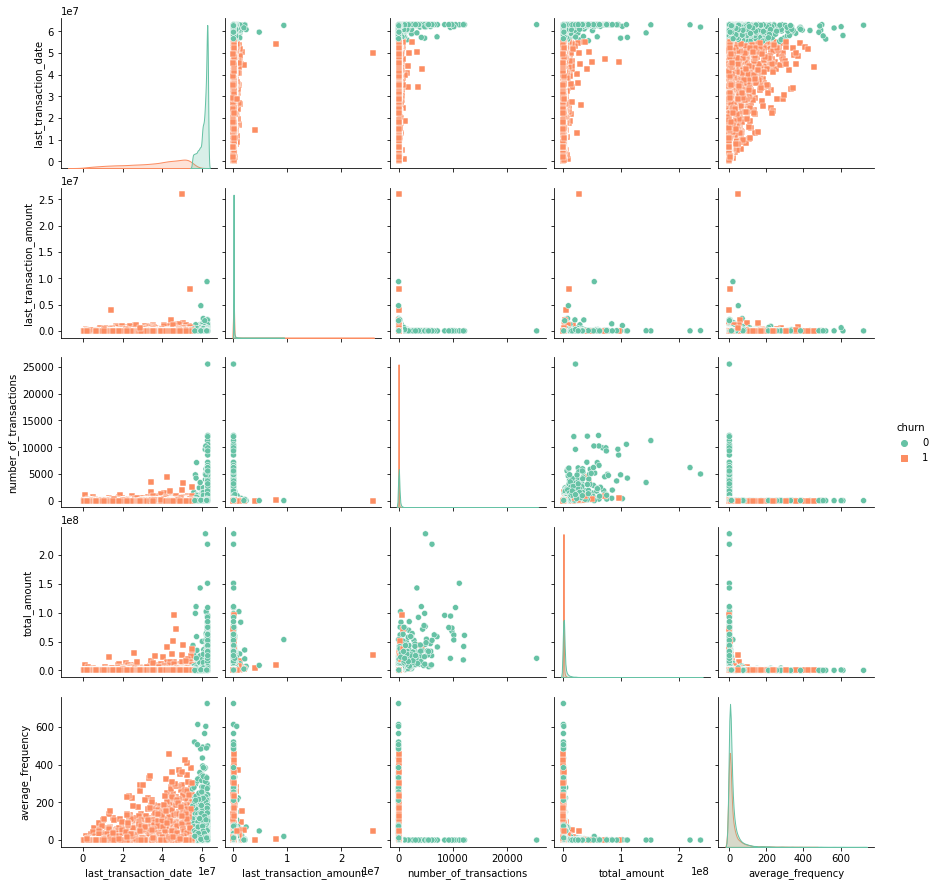

In [114]:
sns.pairplot(merchant_churn_df, kind="scatter", hue="churn",markers=["o", "s"], palette="Set2")

In [ ]:
'''
Since we have used last transaction date to generate the target variable, we see the plots above show a clear separation in hue
for last_transation_date. Hence, we remove the variable from the model. We also see that there are no variables with very 
strong correlation apart from number_of_transactions and total_amount showcasing some.
'''

In [143]:
np.sum(merchant_churn_df['churn'])/len(merchant_churn_df)

0.4098669082293917

In [95]:
np.unique(merchant_churn_df['churn'])

array([0, 1], dtype=int64)

In [96]:
outcome=merchant_churn_df['churn']
merchant_churn_df=merchant_churn_df.drop(['merchant','churn','last_transaction_date'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(merchant_churn_df, outcome, test_size=0.25, random_state=42)

#### Hyperparameter Grid Search and Random forest model:
Choosing optimal hyperparamters is an important part of training the machine learning model.
What we are doing here is with a set of specified values, the model is running on combinations of
all of them and then will output the optimal set of hyperparameters for our dataset
Cross-validation essentially means to divide the dataset into k-sets and hold one out in each new
model training iteration. The benefit of doing that is we know if the model is not succeeding by
chance on our splits

Reason for choosing Random Forests: -> Ensemble of decision trees (Bagging - End up providing
the best combination of trees) -> Reduced overfitting compared to decision trees -> Explainable as
compared to paramteric models like Logistic Regression, SVMs, etc. -> Known to have performed
quite well on tabular datasets and hence adopted for widespread use in the industry -> Handles
missing values, outliers and continuous and categorical values quite well

In [97]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8,9,10],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, refit='accuracy_score')

CV_rfc.fit(x_train, y_train)
print (CV_rfc.best_params_)

{'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 400}


In [98]:
rfc_model=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 400, criterion='entropy', max_depth=6, class_weight='balanced')

# Churn Model Inference

In [99]:
rfc_model.fit(x_train, y_train)
predicted_proba = rfc_model.predict_proba(x_test)

In [107]:
threshold=0.5
predictions = (predicted_proba [:,1] >= threshold).astype('int')

Y_test=list(y_test)
Y_pred=list(predictions)

print("Confusion Matrix:")
print (confusion_matrix(Y_test,Y_pred))

print("Classification report:")
print(classification_report(Y_test,Y_pred,target_names=['Not churned', 'Churned']))

print("Kappa score:")
print(cohen_kappa_score(Y_test,Y_pred))

Confusion Matrix:
[[1368  770]
 [ 350 1100]]
Classification report:
              precision    recall  f1-score   support

 Not churned       0.80      0.64      0.71      2138
     Churned       0.59      0.76      0.66      1450

    accuracy                           0.69      3588
   macro avg       0.69      0.70      0.69      3588
weighted avg       0.71      0.69      0.69      3588

Kappa score:
0.3807272435877679


# Feature Importance from the model

In [108]:
importances = list(rfc_model.feature_importances_)

feature_list = merchant_churn_df.columns

feature_importances = [(feature, round(importance*100, 2)) for feature, importance in zip(feature_list, importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

ft_imp_dict = {}
for i in feature_importances:
    ft_imp_dict[i[0]] = i[1]

In [124]:
feature_importance_df=pd.DataFrame(ft_imp_dict, index=["Feature Importance (%)"]).T

In [125]:
feature_importance_df

,Feature Importance (%)
number_of_transactions,33.79
total_amount,33.15
average_frequency,27.53
last_transaction_amount,5.53
